# Safety in The Hague, Netherlands

`Problem Statement`: Pinpointing the exact causes of crime in a city is challenging as contributing factors are highly nuanced and complex. For example, some hypothesize that crime increases as the income inequality increases. Which variables are the best predictors of crime in The Hague? 

`Project Goal`: Inspect variables of interest that may be correlated with crime levels in The Hague, Netherlands and make statistical predictions on crime rates using machine learning. 

Data from [Den Haag Cijfers](https://denhaag.incijfers.nl/jive) and [CBS](https://www.cbs.nl/nl-nl/reeksen/kerncijfers-wijken-en-buurten-2004-2020).

In [245]:
# Import the necessary libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import requests
import IPython
from IPython.core.display import HTML
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram
from libpysal import weights
from sklearn.datasets import fetch_openml

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

import geopandas as gpd
import palettable as pltt
from seaborn import palplot
import json
import contextily as ctx
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
np.random.seed(123)
from sklearn import cluster
from sklearn.impute import KNNImputer
from sklearn.cluster import AgglomerativeClustering
from libpysal import weights


## Problem Structure

`Hypothesis`: Richer neighborhoods will have fewer offenses and, therefore, be considered safer.
- *Richer* is defined as neighborhoods with low unemployment, a high number of educational establishments, high average disposable income, a high number of private cars, and a high number of businesses/institutions 
- *Safe* means a low number of offenses. 

Key variables:
1. Percent unemployed job seekers
2. Number of educational establishments
3. Average disposable income by household
4. Number of offences
5. Average number of private cars per address
6. Number of businesses and institutions

In [213]:
# Read in shape file
hague_shapefile = gpd.read_file('data/neighborhoods.shp')
hague_shapefile.head()

neighb_cbs        neigb_cijf                                           geometry
0     Oostduinen     70 Oostduinen  POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...
1  Belgisch Park  71 Belgisch Park  POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...
2  Westbroekpark  73 Westbroekpark  POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...
3      Duttendel      74 Duttendel  POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...
4    Nassaubuurt    48 Nassaubuurt  POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...

In [214]:
# Set index of shape file
hague_shapefile = hague_shapefile.set_index('neigb_cijf')
hague_shapefile.plot()

<Axes: >

In [215]:
# Read in csv file and set index
hague_keydata = pd.read_csv('data/The Hague key figures.csv')
hague_keydata = hague_keydata.set_index('Buurten')
hague_keydata.head()

% unemployed job-seekers, total  Number of establishments, education  Average disposable income of private households  All offences Average number of private cars per address (excluding lease cars)  Number of establishments of businesses and institutions
Buurten                                                                                                                                                                                                                                                                                   
01 Oud Scheveningen                                    10.1                                   24                                          33800.0         136.0                                               0.60                                                               389      
02 Vissershaven                                        12.0                                   35                                          40200.0         392.0                                               0.62                                                               670      
03 Scheveningen Badplaats                               6.7                                   57                                          43700.0         421.0                                               0.58                                                               833      
04 Visserijbuurt                                        8.4                                   31                                          40500.0         197.0                                               0.54                                                               475      
05 v Stolkpark/Schev Bosjes                             1.5                                    7                                         103400.0          76.0                                               0.78                                                               118

In [216]:
# Join data from shape file and hague_keydata
hague = hague_shapefile.merge(hague_keydata, left_index=True, right_index=True)
hague.head()

neighb_cbs                                           geometry % unemployed job-seekers, total  Number of establishments, education  Average disposable income of private households  All offences Average number of private cars per address (excluding lease cars)  Number of establishments of businesses and institutions
70 Oostduinen        Oostduinen  POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...                               -                                    0                                              NaN          43.0                                                  x                                                                10      
71 Belgisch Park  Belgisch Park  POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...                             5.1                                   65                                          53000.0         422.0                                               0.72                                                               977      
73 Westbroekpark  Westbroekpark  POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...                             1.9                                    3                                          81500.0         103.0                                               0.88                                                               108      
74 Duttendel          Duttendel  POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...                             3.2                                    6                                         128800.0          74.0                                               0.98                                                               150      
48 Nassaubuurt      Nassaubuurt  POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...                             2.8                                   20                                          97100.0         104.0                                               0.77                                                               438

## Exploratory Data Analysis

In [217]:
# Rename columns to something more manageable
hague = hague.rename(columns={'% unemployed job-seekers, total':'unemploymentrate',
                              'Number of establishments, education':'educestablishments',
                              'Number of establishments of businesses and institutions':'businesses',
                              'All offences':'offences',
                              'Average number of private cars per address (excluding lease cars)':'avgprivatecars',
                              'Average disposable income of private households':'avgdisposableincome'})
hague.head()

neighb_cbs                                           geometry unemploymentrate  educestablishments  avgdisposableincome  offences avgprivatecars  businesses
70 Oostduinen        Oostduinen  POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...                -                   0                  NaN      43.0              x          10
71 Belgisch Park  Belgisch Park  POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...              5.1                  65              53000.0     422.0           0.72         977
73 Westbroekpark  Westbroekpark  POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...              1.9                   3              81500.0     103.0           0.88         108
74 Duttendel          Duttendel  POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...              3.2                   6             128800.0      74.0           0.98         150
48 Nassaubuurt      Nassaubuurt  POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...              2.8                  20              97100.0     104.0           0.77         438

In [218]:
# Drop rows with no data
hague_2 = hague.dropna()
hague_2.drop(hague_2.loc[hague_2['avgprivatecars']=='x'].index, inplace=True)

# Convert string to floats
hague_2["avgdisposableincome"] = pd.to_numeric(hague_2["avgdisposableincome"])
hague_2["avgprivatecars"] = pd.to_numeric(hague_2["avgprivatecars"])
hague_2["unemploymentrate"] = pd.to_numeric(hague_2["unemploymentrate"])
hague_2["educestablishments"] = pd.to_numeric(hague_2["educestablishments"])
hague_2["businesses"] = pd.to_numeric(hague_2["businesses"])
hague_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 105 entries, 71 Belgisch Park to 121 Rietbuurt
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighb_cbs           105 non-null    object  
 1   geometry             105 non-null    geometry
 2   unemploymentrate     105 non-null    float64 
 3   educestablishments   105 non-null    int64   
 4   avgdisposableincome  105 non-null    float64 
 5   offences             105 non-null    float64 
 6   avgprivatecars       105 non-null    float64 
 7   businesses           105 non-null    int64   
dtypes: float64(4), geometry(1), int64(2), object(1)
memory usage: 7.4+ KB


In [12]:
# Boxplot of number of offences
ax = sns.boxplot(x='offences', data=hague_2)
ax.set_ylabel(None);
ax.set_xlabel('offences', fontsize=14);
ax.set_title('Distribution of number of offences in The Hague', fontsize=14);

In [13]:
# There is one outlier neighborhood with high number of offenses
hague_2.nlargest(5,['offences'])

neighb_cbs                                           geometry  unemploymentrate  educestablishments  avgdisposableincome  offences  avgprivatecars  businesses
14 Zuidwal                          Zuidwal  POLYGON ((4.31351 52.07827, 4.31362 52.07822, ...              13.1                  74              30000.0    2376.0            0.29        1410
15 Schildersbuurt-West  Schildersbuurt-West  POLYGON ((4.29696 52.07397, 4.29706 52.07382, ...              20.8                  43              28400.0    1009.0            0.58        1211
18 Huygenspark                  Huygenspark  POLYGON ((4.32012 52.07500, 4.32013 52.07493, ...              14.1                  31              28000.0     957.0            0.26         651
11 Kortenbos                      Kortenbos  POLYGON ((4.30902 52.07817, 4.30902 52.07817, ...              11.0                  57              34500.0     946.0            0.39        1273
13 Uilebomen                      Uilebomen  POLYGON ((4.32019 52.08136, 4.32039 52.08119, ...              11.7                  27              38800.0     888.0            0.36         476

Zuidwal is the outlier that has the highest number of offences.

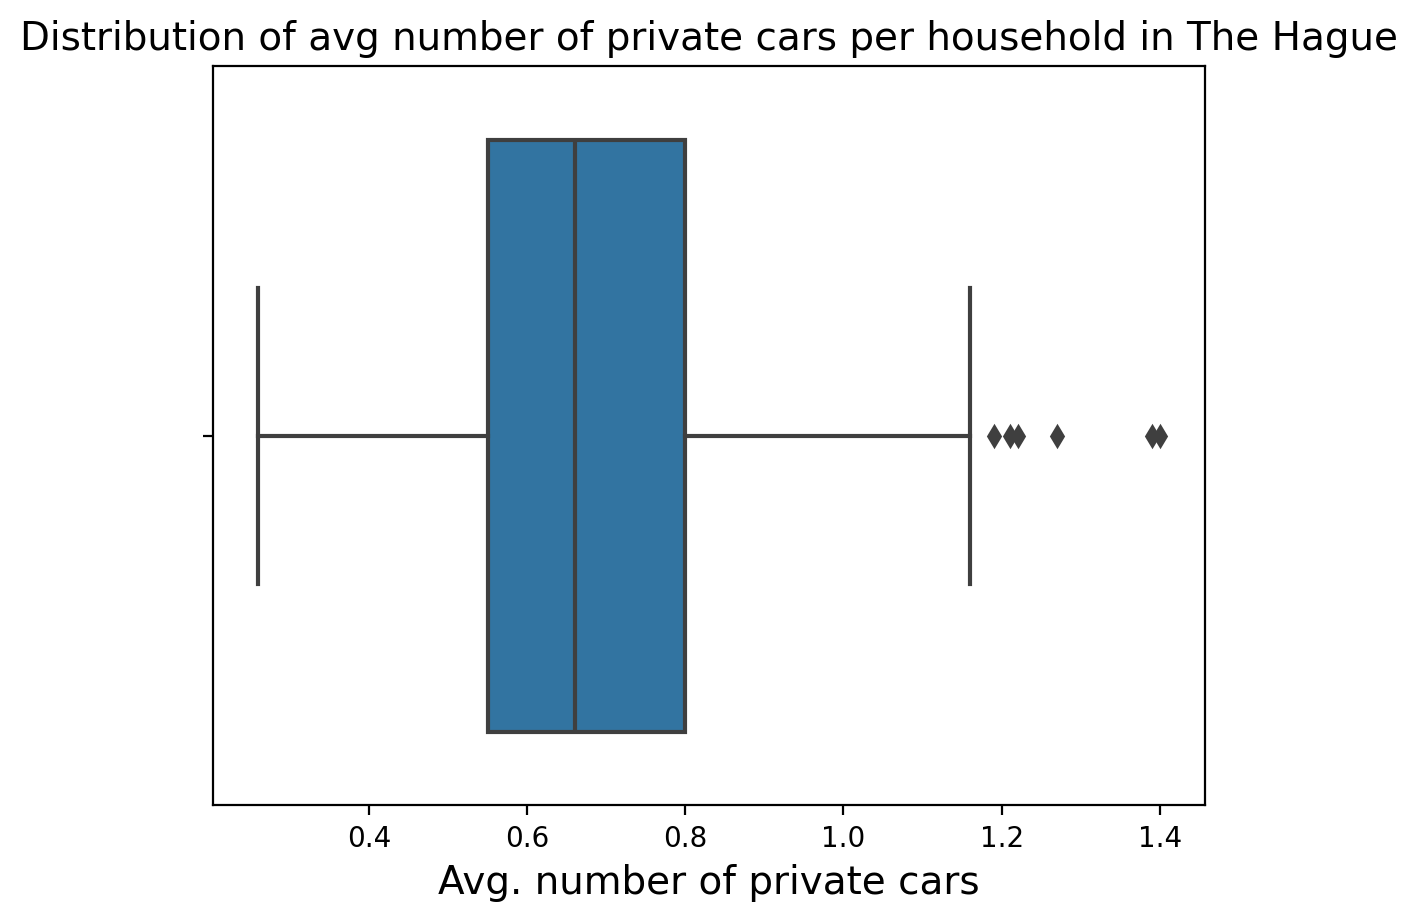

In [14]:
# Boxplot of average number of private cars
ax = sns.boxplot(x=hague_2['avgprivatecars'])
ax.set_ylabel(None);
ax.set_xlabel('Avg. number of private cars', fontsize=14);
ax.set_title('Distribution of avg number of private cars per household in The Hague', fontsize=14);

`Hypothesis`: High income households will have around or more than 1.0 private cars based on the boxplot of average number of private cars.

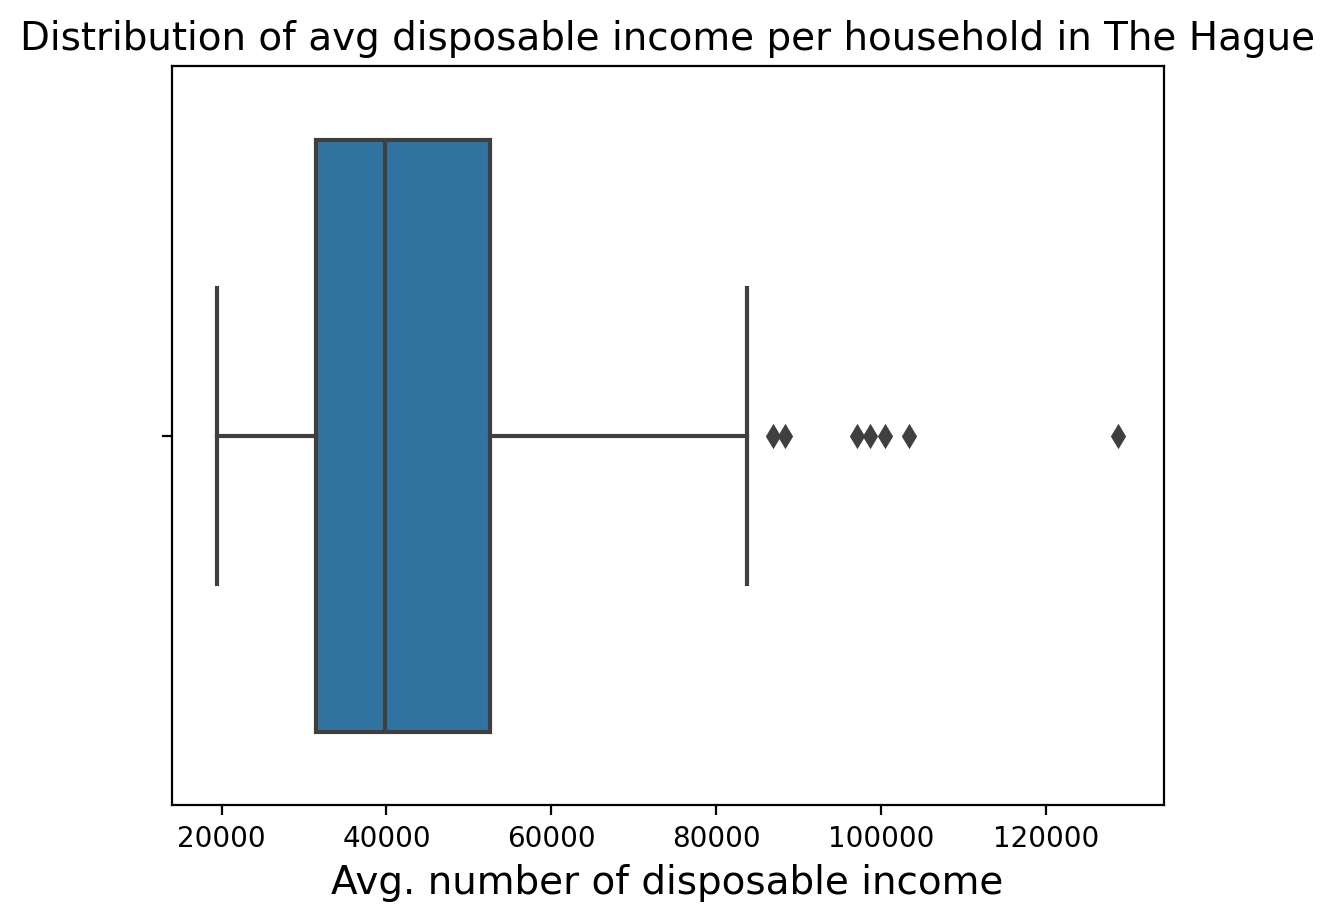

In [15]:
# Boxplot of average disposable income
ax = sns.boxplot(x=hague_2['avgdisposableincome'])
ax.set_ylabel(None);
ax.set_xlabel('Avg. number of disposable income', fontsize=14);
ax.set_title('Distribution of avg disposable income per household in The Hague', fontsize=14);

`Hypothesis`: High income neighborhoods will have higher private car ownership and lower offenses.

In [8]:
# Boxplots of the unemployment rate
ax = sns.boxplot(x='unemploymentrate', data=hague_2)
ax.set_ylabel(None);
ax.set_xlabel('Unemployment Rate %', fontsize=14);
ax.set_title('Distribution of unemployment rate in The Hague', fontsize=14);

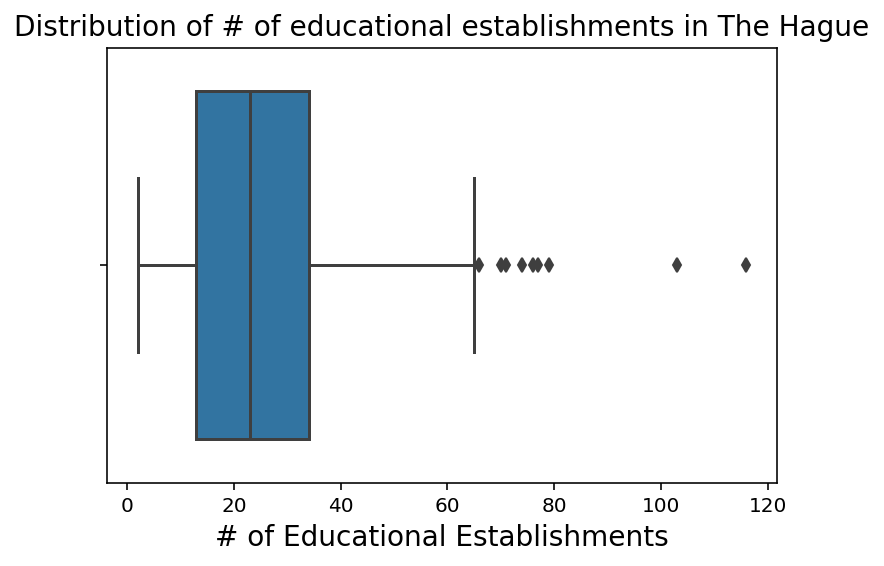

In [9]:
ax = sns.boxplot(x='educestablishments', data=hague_2)
ax.set_ylabel(None);
ax.set_xlabel('# of Educational Establishments', fontsize=14);
ax.set_title('Distribution of # of educational establishments in The Hague', fontsize=14);

There are multiple outliers for educational establishments.

In [10]:
ax = sns.boxplot(x='businesses', data=hague_2)
ax.set_ylabel(None);
ax.set_xlabel('# of Businesses / Institutions', fontsize=14);
ax.set_title('Distribution of # of businesses/institutions in The Hague', fontsize=14);

In [17]:
# Find the top 10 neighborhoods with highest number of avg private cars
cars = hague_2.nlargest(10,['avgprivatecars'])
cars.sort_values(by=['neighb_cbs'], inplace=True)
cars

neighb_cbs                                           geometry  unemploymentrate  educestablishments  avgdisposableincome  offences  avgprivatecars  businesses
108 Bosweide                        Bosweide  POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...               2.9                   7             100500.0      65.0            1.39         163
115 De Bras                          De Bras  POLYGON ((4.38118 52.03639, 4.38437 52.03776, ...               6.6                  29              60200.0     138.0            1.21         456
118 De Lanen                        De Lanen  POLYGON ((4.40245 52.06319, 4.40242 52.06314, ...               5.2                  33              56000.0     188.0            1.16         349
119 De Velden                      De Velden  POLYGON ((4.40593 52.07659, 4.40607 52.07649, ...               5.8                  23              54800.0     169.0            1.15         290
120 De Vissen                      De Vissen  POLYGON ((4.41188 52.07213, 4.41192 52.07210, ...               5.4                  49              54800.0      56.0            1.19         567
90 Ockenburgh                     Ockenburgh  POLYGON ((4.22328 52.06641, 4.22334 52.06634, ...               3.3                   5              88400.0     251.0            1.40         100
103 Parkbuurt Oosteinde  Parkbuurt oosteinde  POLYGON ((4.29789 52.02947, 4.29791 52.02945, ...               3.4                  17              67600.0      79.0            1.27         267
121 Rietbuurt                      Rietbuurt  POLYGON ((4.41539 52.05744, 4.41538 52.05707, ...               6.2                   9              56100.0      84.0            1.14         174
09 Vogelwijk                       Vogelwijk  POLYGON ((4.26475 52.09163, 4.26489 52.09151, ...               2.5                  48              80600.0     247.0            1.11         595
105 Zonne Veld                    Zonne Veld  POLYGON ((4.30419 52.02215, 4.30427 52.02206, ...               6.2                  14              52300.0     121.0            1.22         276

In [18]:
# Find the top 10 neighborhoods with highest avg disposable income
income = hague_2.nlargest(10,['avgdisposableincome'])
income.sort_values(by=['neighb_cbs'], inplace=True)
income

neighb_cbs                                           geometry  unemploymentrate  educestablishments  avgdisposableincome  offences  avgprivatecars  businesses
78 Arendsdorp                                          Arendsdorp  POLYGON ((4.32329 52.09921, 4.32388 52.09870, ...               3.4                  13              83700.0      75.0            0.74         169
108 Bosweide                                             Bosweide  POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...               2.9                   7             100500.0      65.0            1.39         163
74 Duttendel                                            Duttendel  POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...               3.2                   6             128800.0      74.0            0.98         150
68 Marlot                                                  Marlot  POLYGON ((4.35883 52.10553, 4.35884 52.10552, ...               1.7                   6              98700.0      38.0            1.11         106
48 Nassaubuurt                                        Nassaubuurt  POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...               2.8                  20              97100.0     104.0            0.77         438
90 Ockenburgh                                          Ockenburgh  POLYGON ((4.22328 52.06641, 4.22334 52.06634, ...               3.3                   5              88400.0     251.0            1.40         100
05 v Stolkpark/Schev Bosjes  Van Stolkpark en Scheveningse Bosjes  POLYGON ((4.28612 52.10404, 4.28637 52.10415, ...               1.5                   7             103400.0      76.0            0.78         118
09 Vogelwijk                                            Vogelwijk  POLYGON ((4.26475 52.09163, 4.26489 52.09151, ...               2.5                  48              80600.0     247.0            1.11         595
77 Waalsdorp                                            Waalsdorp  POLYGON ((4.32270 52.09912, 4.32271 52.09910, ...               2.4                  32              86900.0     134.0            0.87         448
73 Westbroekpark                                    Westbroekpark  POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...               1.9                   3              81500.0     103.0            0.88         108

Looking at the top 10 safest and highest income neighborhoods (based on disposable income and private car ownership), there is little overlap between the safe neighborhoods and highest income neighborhoods. Only the following neighborhoods overlap:
- Bosweide
- De Vissen
- Marlot
- Ockenburgh

This could be due to the fact that people spend their disposable income on other things besides private cars. Also, high income neighborhoods may attract offenses since it is a higher valued area.

## Choropleths

In [19]:
# Number of offences by neighborhood
ax = hague_2.plot(column='offences', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)
# Customizing format of chloropleth
ax.axis('off')
ax.set_title('Number of offences by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

In [20]:
# Avg private cars by neighborhood
ax = hague_2.plot(column='avgprivatecars', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)
# Customizing format of chloropleth
ax.axis('off')
ax.set_title('Avg private cars by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

In [21]:
# Avg disposable income by neighborhood
ax = hague_2.plot(column='avgdisposableincome', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)
# Customizing format of chloropleth
ax.axis('off')
ax.set_title('Avg disposable income by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

The highest income neighborhoods are closer to the coast.

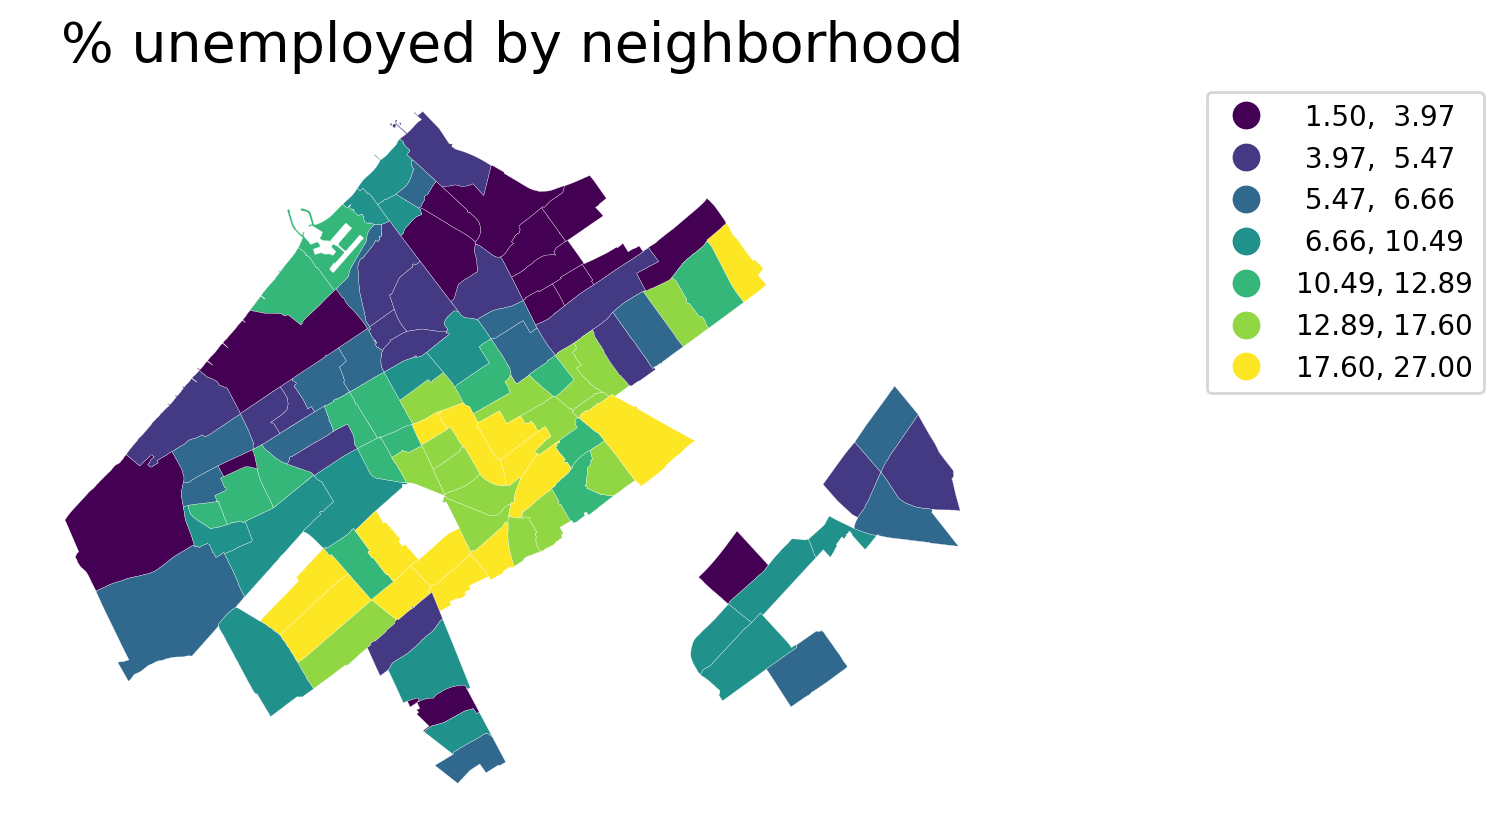

In [22]:
# Unemployment rate by neighborhood
ax = hague_2.plot(column='unemploymentrate', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)

# Customizing format of chloropleth
ax.axis('off')
ax.set_title('% unemployed by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

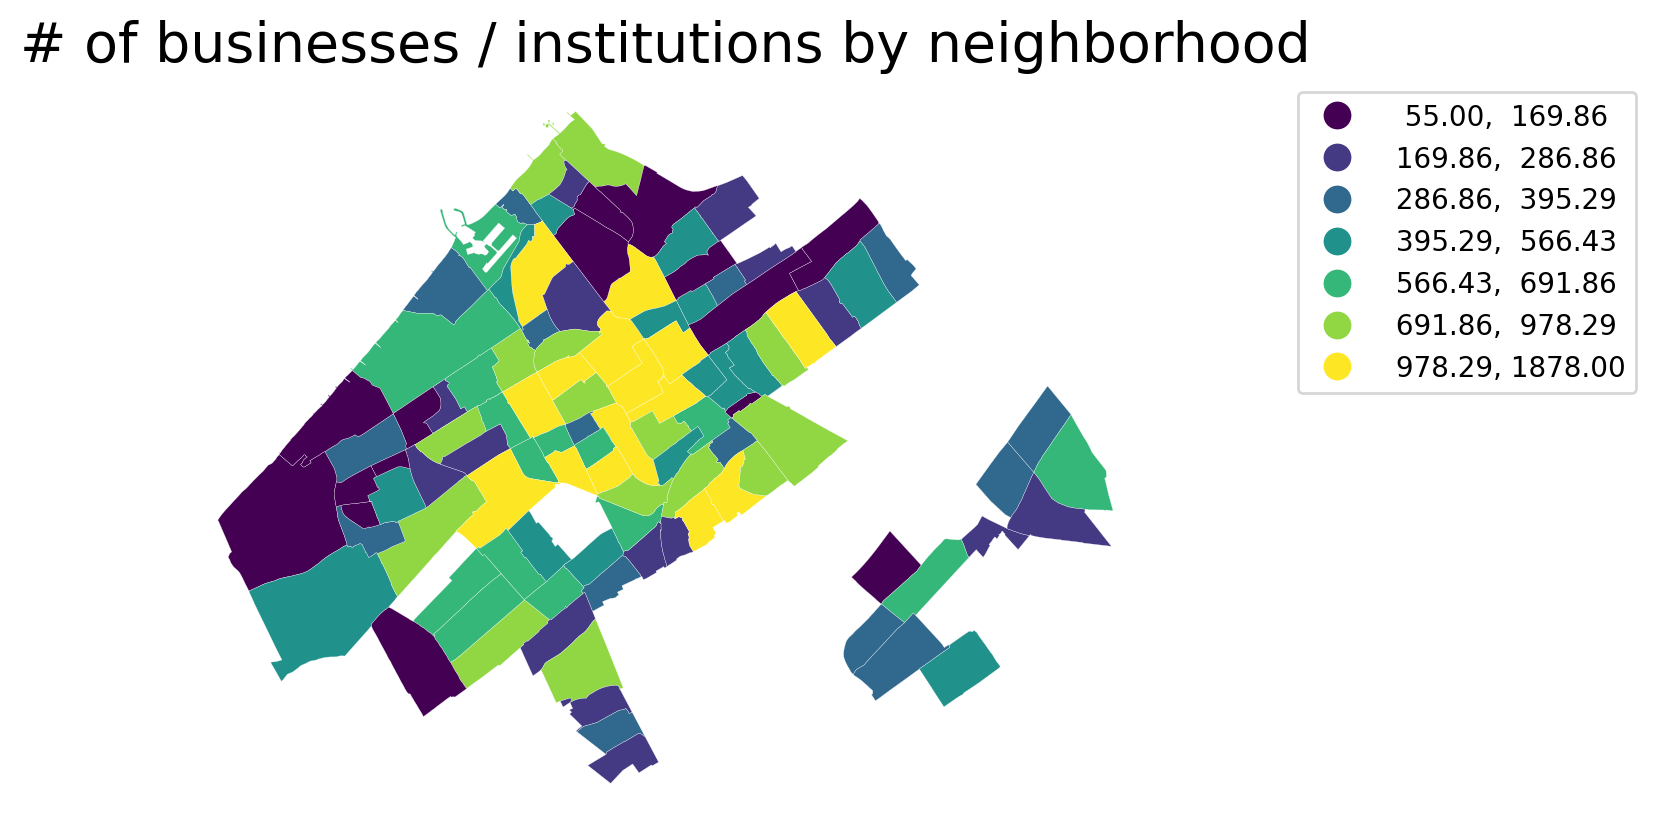

In [23]:
# Number of businesses / institutions by neighborhood
ax = hague_2.plot(column='businesses', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)

# Customizing format of chloropleth
ax.axis('off')
ax.set_title('# of businesses / institutions by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

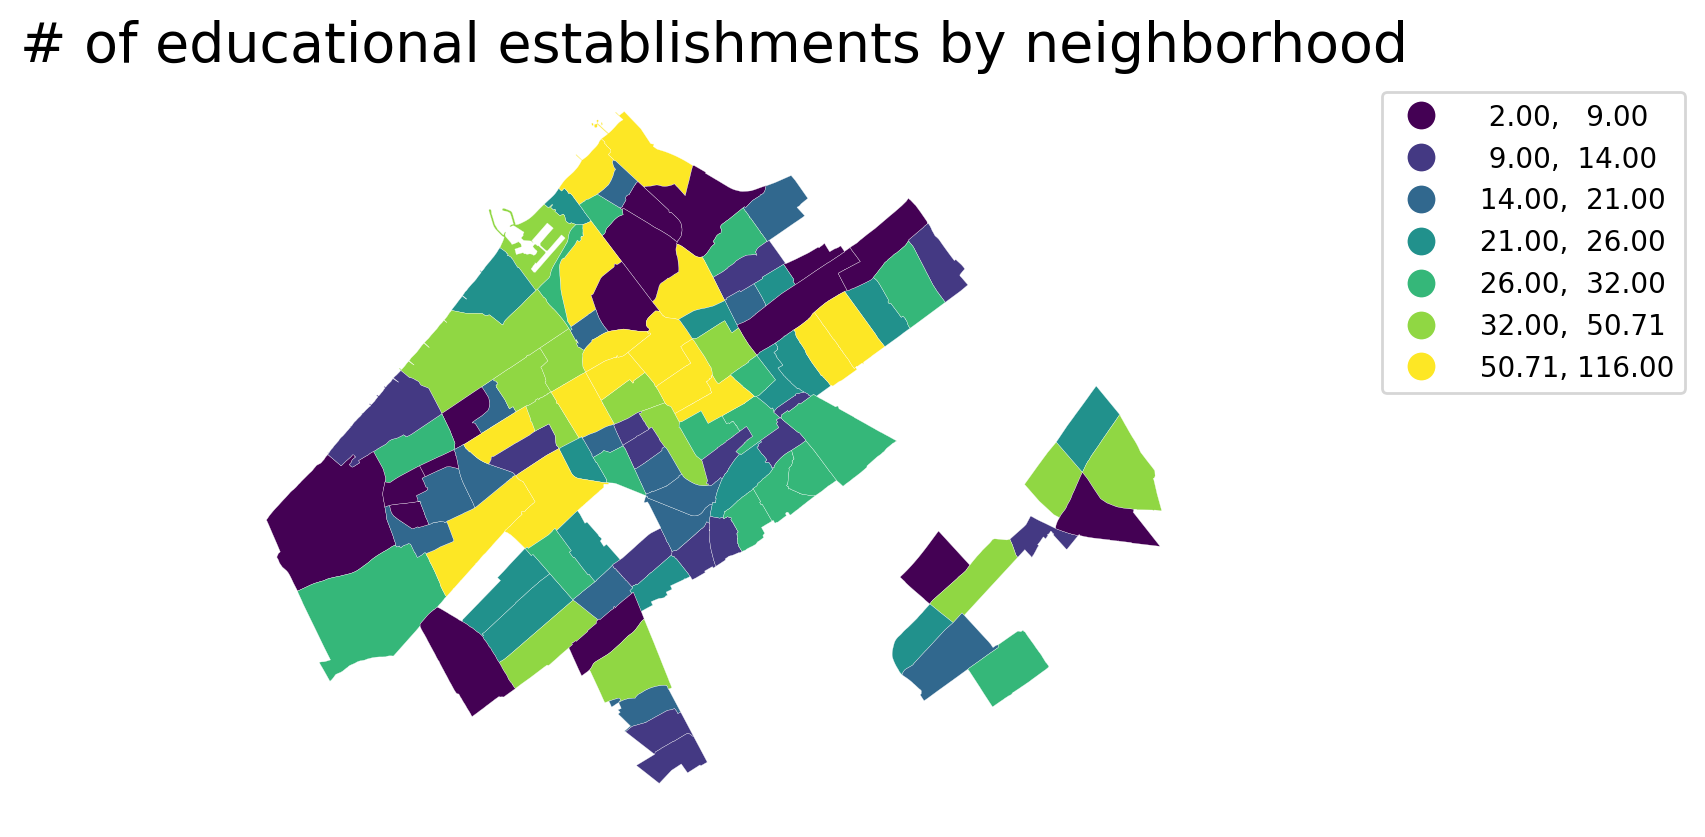

In [24]:
# Number of educational establishments by neighborhood
ax = hague_2.plot(column='educestablishments', scheme='QUANTILES', alpha=1, k=7, \
            cmap=plt.cm.viridis,
            edgecolor='w', linewidth=0.1, legend=True)

# Customizing format of chloropleth
ax.axis('off')
ax.set_title('# of educational establishments by neighborhood', fontdict={'fontsize': 20})
ax.get_legend().set_bbox_to_anchor((1.5,1))

## Spatial Analysis

In [14]:
%time w = weights.Queen.from_dataframe(hague_2, idVariable='neighb_cbs')

Wall time: 301 ms


In [15]:
# Check the neighbors of the highest income neighborhood, Duttendel
w['Duttendel']

{'Westbroekpark': 1.0,
 'Waalsdorp': 1.0,
 'Belgisch Park': 1.0,
 'Archipelbuurt': 1.0,
 'Van Stolkpark en Scheveningse Bosjes': 1.0,
 'Duinzigt': 1.0}

In [16]:
# Row standardize the matrix
w.transform = 'R'
w['Duttendel']

{'Westbroekpark': 0.16666666666666666,
 'Waalsdorp': 0.16666666666666666,
 'Belgisch Park': 0.16666666666666666,
 'Archipelbuurt': 0.16666666666666666,
 'Van Stolkpark en Scheveningse Bosjes': 0.16666666666666666,
 'Duinzigt': 0.16666666666666666}

In [17]:
# Spatial lag
hague_2['w_avgdisposableincome'] = weights.lag_spatial(w, hague_2['avgdisposableincome'])
hague_2.sort_values(by=['avgdisposableincome'], ascending=False, inplace=True)
# Checking the value for Duttendel
hague_3 = hague_2.set_index('neighb_cbs')
duttendel = hague_3.loc[w.neighbors['Duttendel'], 'avgdisposableincome']
duttendel

neighb_cbs
Westbroekpark                            81500.0
Waalsdorp                                86900.0
Belgisch Park                            53000.0
Archipelbuurt                            74800.0
Van Stolkpark en Scheveningse Bosjes    103400.0
Duinzigt                                 61100.0
Name: avgdisposableincome, dtype: float64

In [18]:
duttendel.mean()

76783.33333333333

The mean average disposable income of the neighbors of Duttendel is 76,783.

In [19]:
# Standarisizing data
hague_2['std_avgdisposableincome'] = (hague_2['avgdisposableincome'] - hague_2['avgdisposableincome'].mean()) / hague_2['avgdisposableincome'].std()
hague_2['w_std_avgdisposableincome'] = weights.lag_spatial(w, hague_2['std_avgdisposableincome'])
hague_2.head(3)

neighb_cbs                                           geometry  unemploymentrate  educestablishments  avgdisposableincome  offences  avgprivatecars  businesses  w_avgdisposableincome  std_avgdisposableincome  w_std_avgdisposableincome
74 Duttendel                                            Duttendel  POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...               3.2                   6             128800.0      74.0            0.98         150           37650.000000                 4.077847                  -0.217795
05 v Stolkpark/Schev Bosjes  Van Stolkpark en Scheveningse Bosjes  POLYGON ((4.28612 52.10404, 4.28637 52.10415, ...               1.5                   7             103400.0      76.0            0.78         118           42300.000000                 2.834436                   0.283975
108 Bosweide                                             Bosweide  POLYGON ((4.37400 52.04875, 4.37394 52.04870, ...               2.9                   7             100500.0      65.0            1.39         163           45583.333333                 2.692472                  -0.431965

Because the average disposable income of Duttendel is such an outlier, the mean average disposable income of neighbors is much lower than itself. It has a relatively high average number of private cars and low offences which is consistent with my hypothesis.

## Local Spatial Correlation

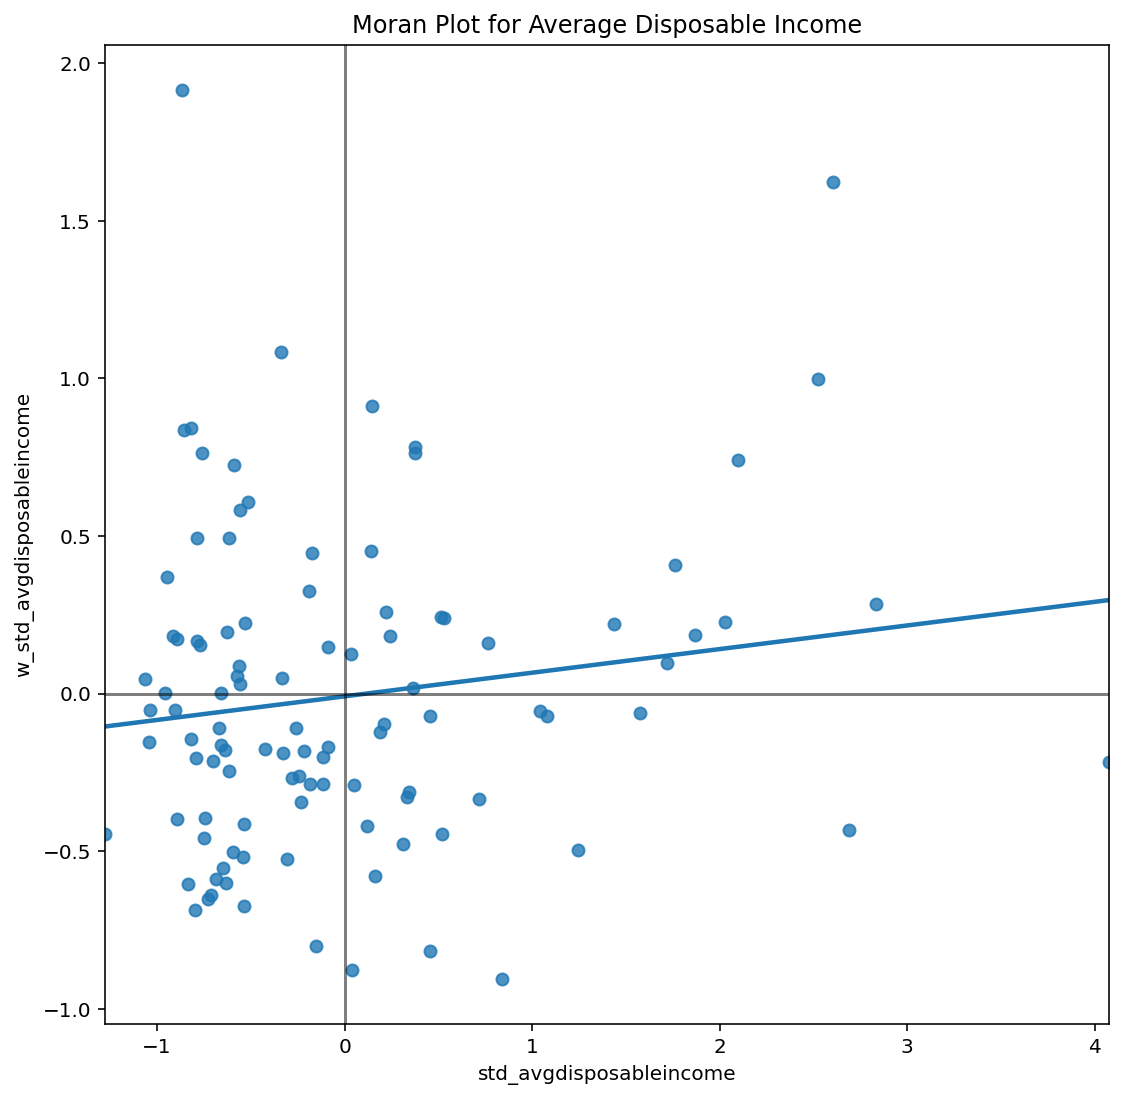

In [20]:
# Setup Moran Plot for average disposable income
f, ax = plt.subplots(1, figsize=(9,9))
sns.regplot(x='std_avgdisposableincome', y='w_std_avgdisposableincome', data=hague_2, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot for Average Disposable Income')
plt.show()

The trendline is positive though not that steep which means that higher income neighborhoods tend to be located close to each other. Because the line is not that steep, it means that there are neighborhoods of high income that are close to those of much lower income. 

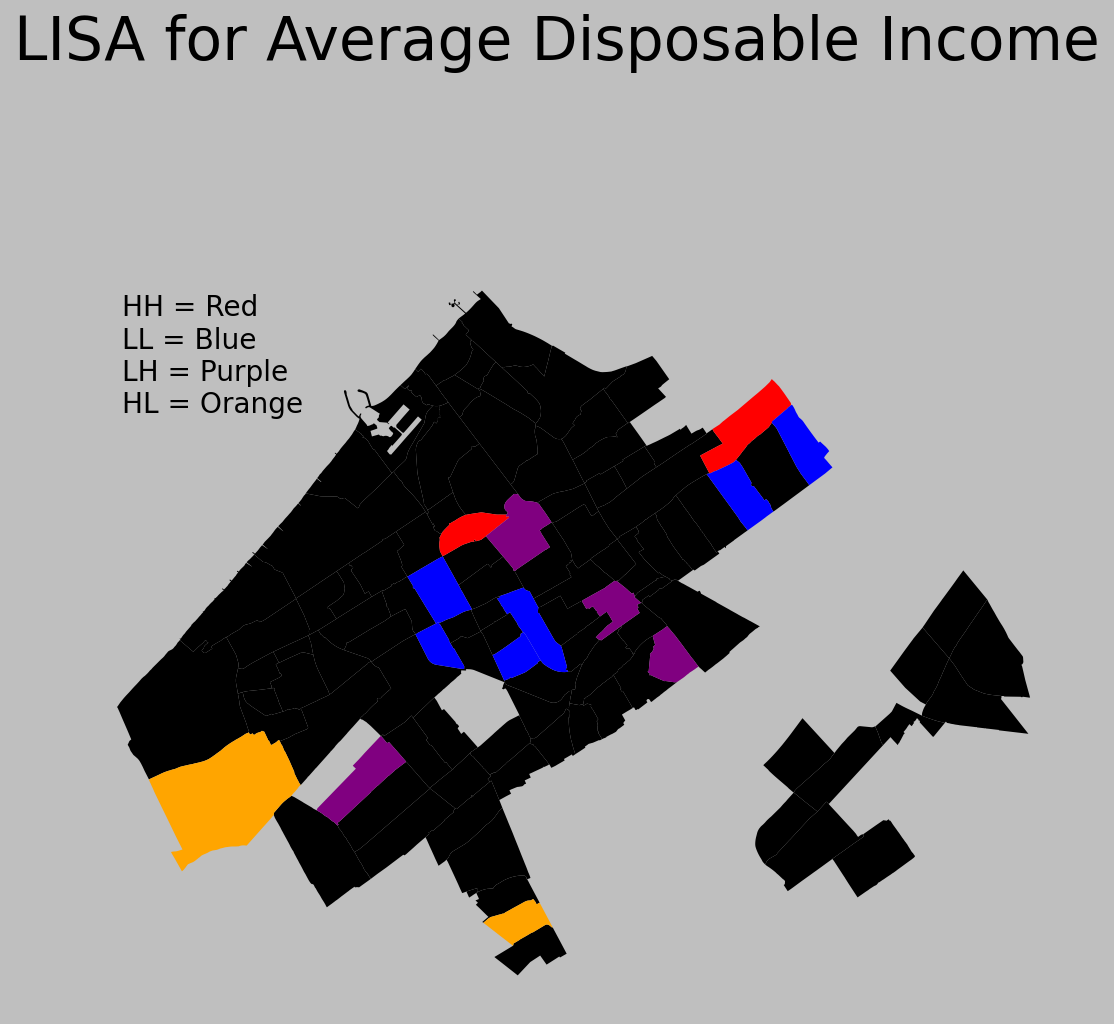

In [21]:
# Calculate LISAs and plot them
lisa = esda.Moran_Local(hague_2['avgdisposableincome'], w)
hague_2['significant'] = lisa.p_sim < 0.05
hague_2['quadrant'] = lisa.q

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot insignificant clusters
ns = hague_2.loc[hague_2['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')

# Plot HH clusters
hh = hague_2.loc[(hague_2['quadrant']==1) & (hague_2['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')

# Plot LL clusters
ll = hague_2.loc[(hague_2['quadrant']==3) & (hague_2['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')

# Plot LH clusters
lh = hague_2.loc[(hague_2['quadrant']==2) & (hague_2['significant']==True), 'geometry']
lh.plot(ax=ax, color='purple')

# Plot HL clusters
hl = hague_2.loc[(hague_2['quadrant']==4) & (hague_2['significant']==True), 'geometry']
hl.plot(ax=ax, color='orange')

# Style and draw
f.suptitle('LISA for Average Disposable Income', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
legend = '\n'.join(('HH = Red', 'LL = Blue', 'LH = Purple', 'HL = Orange'))
ax.text(0.05,0.95,legend,transform=ax.transAxes,fontsize=14,verticalalignment='top')
plt.show()

In red are the neighborhoods that are relatively high income and also surrounded by other high income neighborhoods.

In orange are neighborhoods that are relatively high income but surrounded by lower income neighborhoods.

In purple are neigborhoods that are relatively low income but surrounded by higher income neighborhoods. 

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

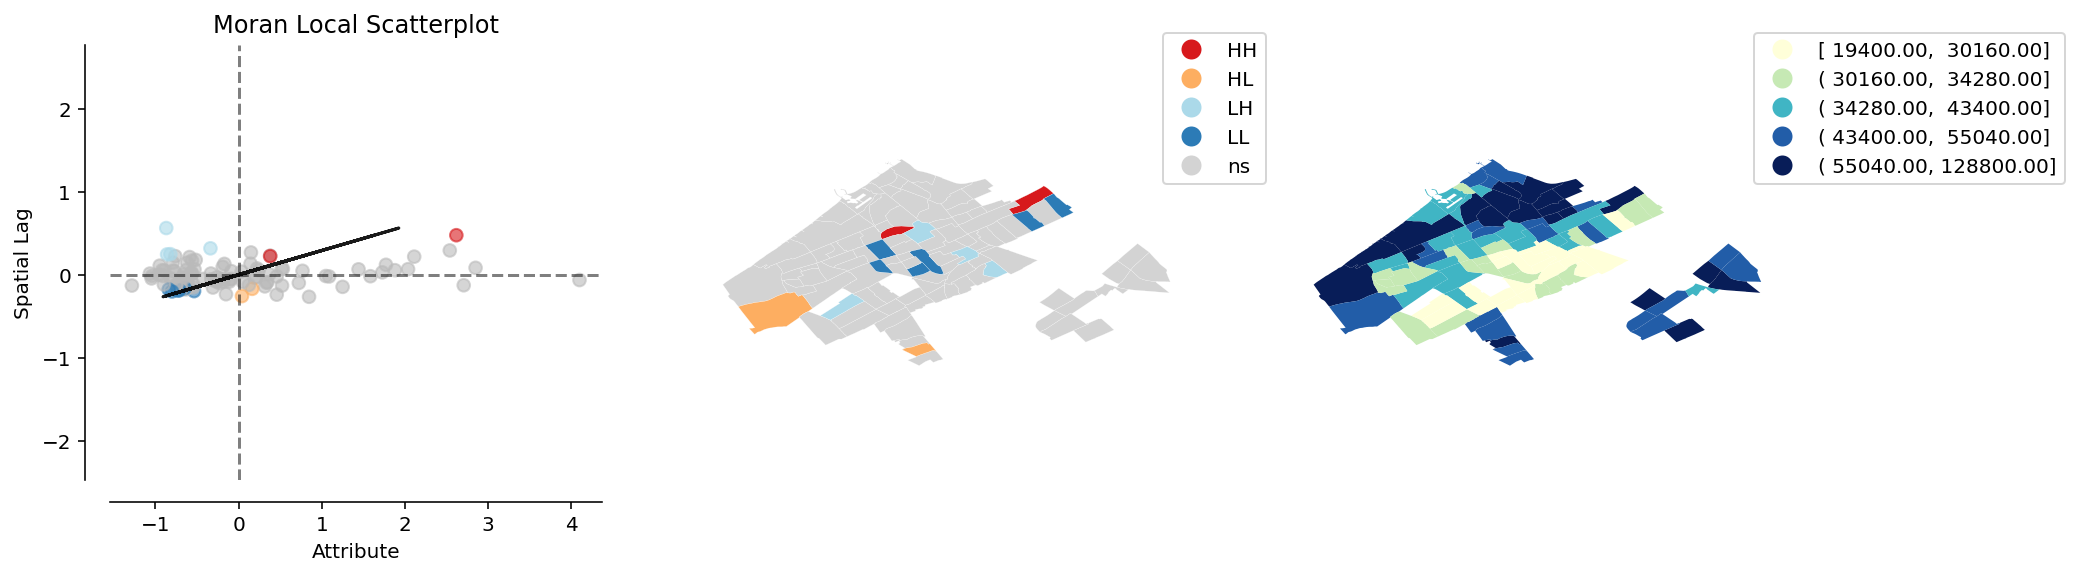

In [22]:
plot_local_autocorrelation(lisa, hague_2, 'avgdisposableincome')

## Linear Regression with full validation set

I would like to perform a linear regression on certain variables to assess how well the number of educational establishments is a predictor of unemployment rate. I will start with unemployment rate and educational establishments. My hypothesis is that these two variables would be inversely related - there would be a higher unemployment rate with less educational establishments in the neighborhood.

(105, 1) (105,)


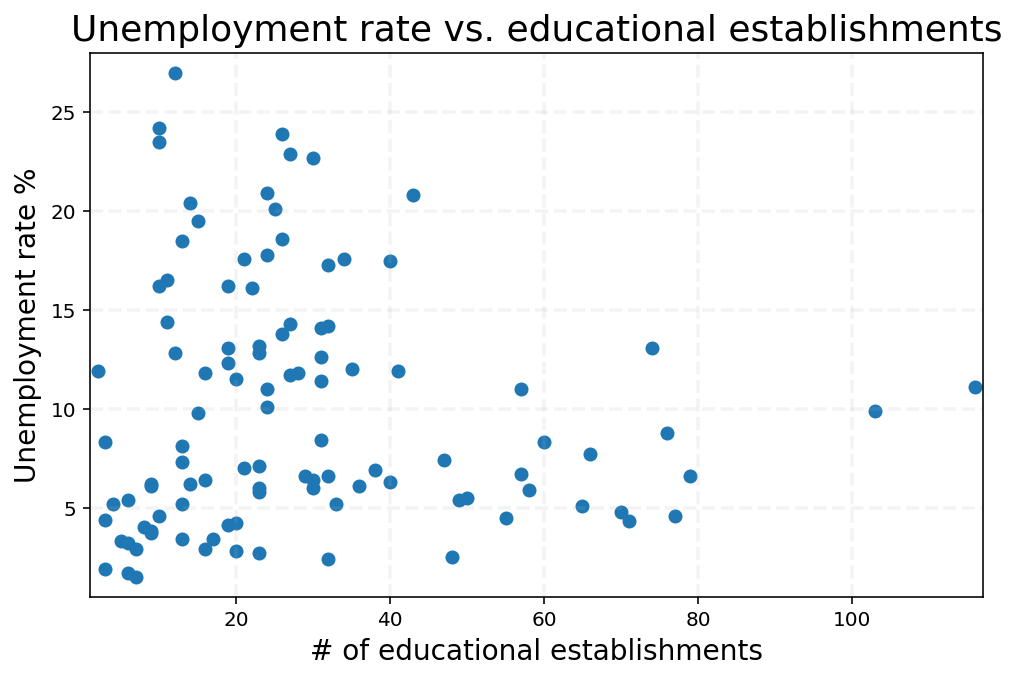

In [23]:
# Create array of relevant variables - unemployment rate and educational establishments
x_educ = np.array(hague_2['educestablishments'])
y_unemployment = np.array(hague_2['unemploymentrate'])
x_educ = x_educ.reshape(105,1)
print(x_educ.shape, y_unemployment.shape)

# Plot values on scatterplot
fig, ax = plt.subplots(1,1, figsize=(8,5)) # Create figure object
ax.set_xlim(np.min(x_educ)-1, np.max(x_educ) + 1)
ax.set_ylim(np.min(y_unemployment)-1, np.max(y_unemployment) + 1)
ax.set_xlabel('# of educational establishments', fontsize = 14)
ax.set_ylabel('Unemployment rate %', fontsize = 14)
ax.set_title('Unemployment rate vs. educational establishments', fontsize = 18)
ax.grid(True, lw=1.75, ls='--', alpha=0.15)
ax = plt.scatter(x_educ, y_unemployment)

Now, I will find the best fit line and also check the least squares. 

In [24]:
def linear_regression_fit(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    x = x.reshape(x.shape[0], 1)
    y = y.reshape(x.shape[0], 1)
    y_bar = np.mean(y)
    x_bar = np.mean(x)
    numerator = np.sum( (x - x_bar)*(y - y_bar) )
    denominator = np.sum((x - x_bar)**2)
    beta_1 = numerator/denominator
    beta_0 = y_bar - beta_1*x_bar

    return beta_0, beta_1

betas = linear_regression_fit(x_educ,y_unemployment)
beta_0 = betas[0]
beta_1 = betas[1]

print("The best-fit line is {0:3.2f} + {1:3.3f} * x".format(beta_0, beta_1))
print("The best fit is {0:3.2f}".format(beta_0))

The best-fit line is 10.45 + -0.015 * x
The best fit is 10.45


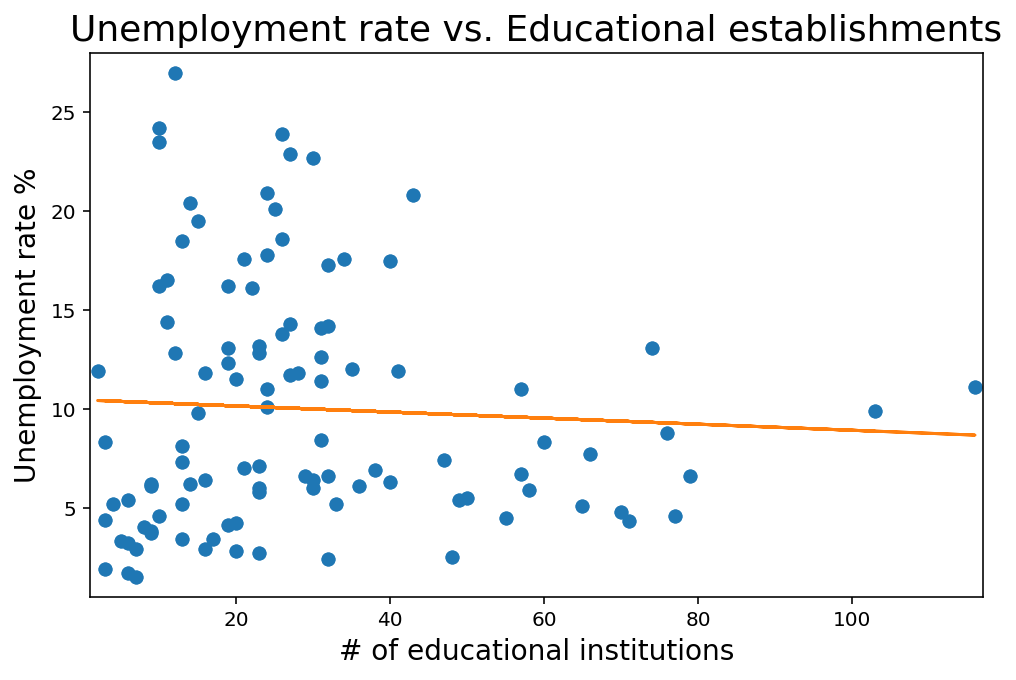

In [25]:
# Plot the best fit line with data
def scatter_bestfit(x, y, title, x_axis, y_axis):
    fig, ax = plt.subplots(1, 1, figsize=(8,5)) # Create figure object
   
    # set axes limits to make the scale nice
    ax.set_xlim(np.min(x)-1, np.max(x) + 1)
    ax.set_ylim(np.min(y)-1, np.max(y) + 1)
    
    # set axes labels
    ax.set_xlabel(x_axis, fontsize = 14)
    ax.set_ylabel(y_axis, fontsize = 14)
    
    # set figure title 
    ax.set_title(title, fontsize = 18)
    
    ax = plt.scatter(x, y)
    
    x = x.reshape(x.shape[0], 1)
    y = y.reshape(y.shape[0], 1)
    y_bar = np.mean(y)
    x_bar = np.mean(x)
    numerator = np.sum( (x - x_bar)*(y - y_bar) )
    denominator = np.sum((x - x_bar)**2)
    beta_1 = numerator/denominator
    beta_0 = y_bar - beta_1*x_bar
    ax = plt.plot(x, y, 'o')
    ax = plt.plot(x, beta_1*x + beta_0)
    
    return ax
    
scatter_bestfit(x_educ, y_unemployment, 'Unemployment rate vs. Educational establishments', '# of educational institutions', 'Unemployment rate %')

It seems like there is a slight negative correlation between the two variables, though not as much as I had first hypothesized. Next, I will look at the results using OLS.

In [26]:
import statsmodels.api as sm
def ols_summary(x, y):
    regr = sm.OLS(y, sm.add_constant(x))
    results = regr.fit()
    return results.summary()

ols_summary(x_educ, y_unemployment)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3042
Date:                Wed, 14 Oct 2020   Prob (F-statistic):              0.582
Time:                        17:21:02   Log-Likelihood:                -339.72
No. Observations:                 105   AIC:                             683.4
Df Residuals:                     103   BIC:                             688.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4507      1.001     10.442      0.000       8.466      12.436
x1            -0.0153      0.028     -0.552      0.582      -0.071       0.040
==============================================================================
Omnibus:                        8.931   Durbin-Watson:                   0.229
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.460
Skew:                           0.707   Prob(JB):                      0.00883
Kurtosis:                       2.600   Cond. No.                         59.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared value is very low so there is very little if not any correlation between unemployment rate and number of educational institutions. There is also a high number of residuals which means there's a substantial difference between the model and the actual data. 
I will now assess the relatedness of unemployment rate and average dispoable income. My hypothesis is that they would be inversely related as well. 

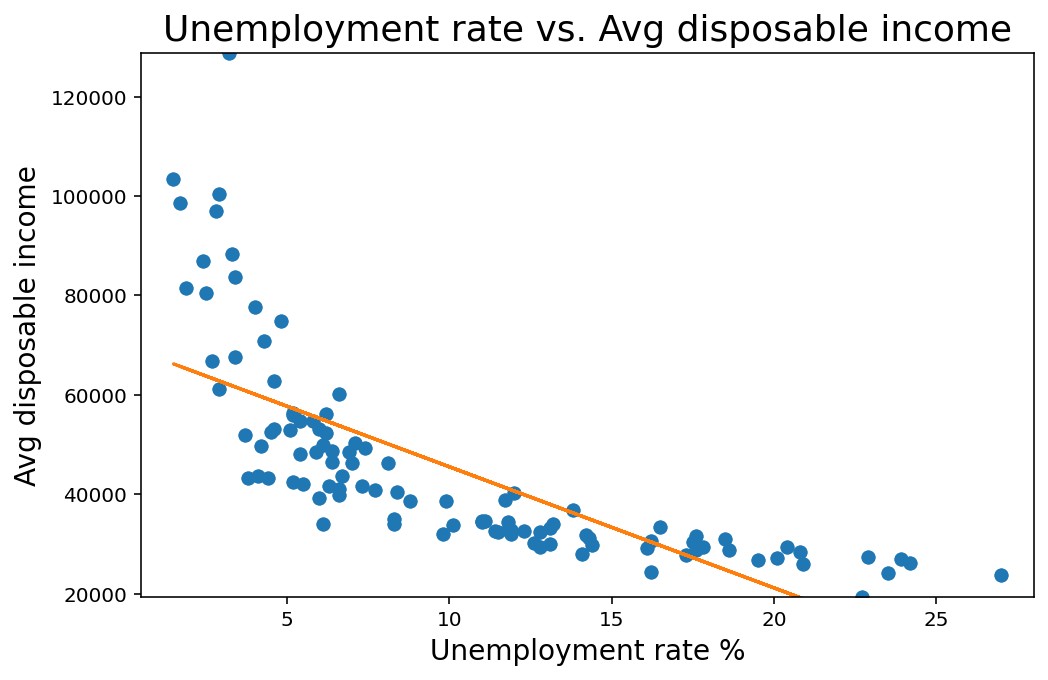

In [27]:
y_dispincome = np.array(hague_2['avgdisposableincome'])
x_unemployment = np.array(hague_2['unemploymentrate'])
x_unemployment = x_unemployment.reshape(105,1)

scatter_bestfit(x_unemployment, y_dispincome, 'Unemployment rate vs. Avg disposable income', 'Unemployment rate %', 'Avg disposable income')

In [28]:
betas = linear_regression_fit(x_unemployment,y_dispincome)
beta_0 = betas[0]
beta_1 = betas[1]

print("The best-fit line is {0:3.2f} + {1:3.3f} * x".format(beta_0, beta_1))
print("The best fit is {0:3.2f}".format(beta_0))

The best-fit line is 69897.31 + -2437.041 * x
The best fit is 69897.31


In [29]:
ols_summary(x_unemployment, y_dispincome)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     123.4
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           2.53e-19
Time:                        17:21:03   Log-Likelihood:                -1149.2
No. Observations:                 105   AIC:                             2302.
Df Residuals:                     103   BIC:                             2308.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.99e+04   2578.222     27.111      0.000    6.48e+04     7.5e+04
x1         -2437.0409    219.340    -11.111      0.000   -2872.051   -2002.031
==============================================================================
Omnibus:                       52.314   Durbin-Watson:                   0.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.787
Skew:                           1.811   Prob(JB):                     5.46e-35
Kurtosis:                       7.790   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the R-squared value, there is a stronger inverse correlation between unemployment rate and average disposable income, which is consistent with my hypothesis. The next analysis that would make sense would be to see if unemployment rate and number of businesses are correlated. Again, my hypothesis is that these variables should be inversely correlated.

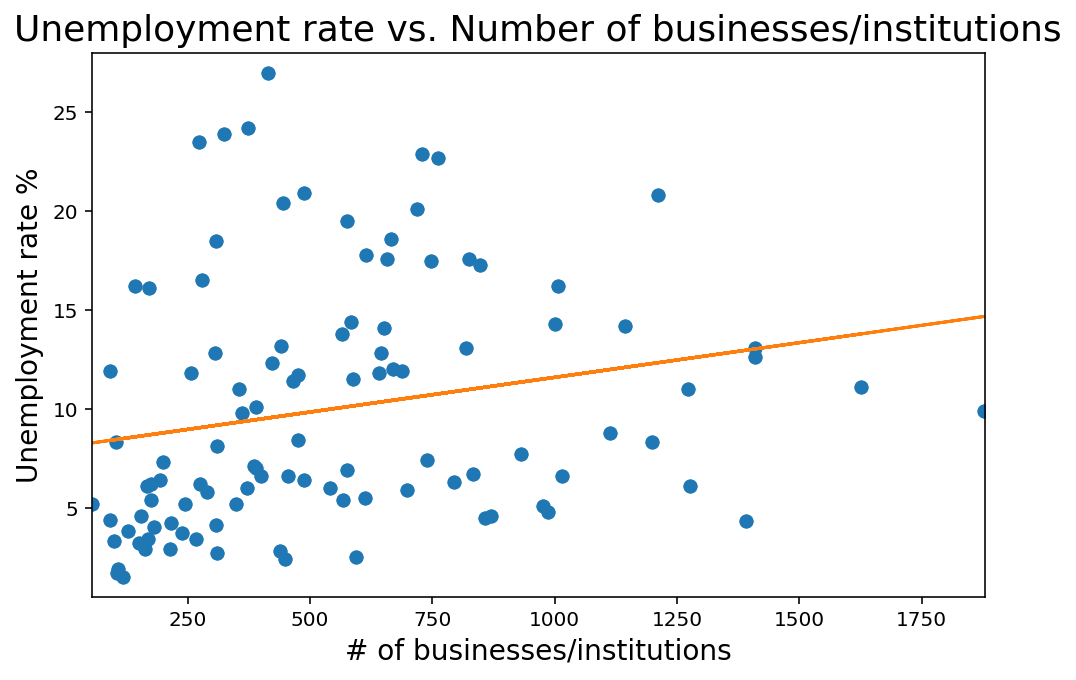

In [30]:
y_unemployment = np.array(hague_2['unemploymentrate'])
x_businesses = np.array(hague_2['businesses'])
x_businesses = x_businesses.reshape(105,1)

scatter_bestfit(x_businesses, y_unemployment, 'Unemployment rate vs. Number of businesses/institutions', '# of businesses/institutions', 'Unemployment rate %')

In [31]:
betas = linear_regression_fit(x_businesses,y_unemployment)
beta_0 = betas[0]
beta_1 = betas[1]

print("The best-fit line is {0:3.2f} + {1:3.3f} * x".format(beta_0, beta_1))
print("The best fit is {0:3.2f}".format(beta_0))

The best-fit line is 8.08 + 0.004 * x
The best fit is 8.08


In [32]:
ols_summary(x_businesses, y_unemployment)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.967
Date:                Wed, 14 Oct 2020   Prob (F-statistic):             0.0280
Time:                        17:21:03   Log-Likelihood:                -337.40
No. Observations:                 105   AIC:                             678.8
Df Residuals:                     103   BIC:                             684.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0828      1.049      7.706      0.000       6.003      10.163
x1             0.0035      0.002      2.229      0.028       0.000       0.007
==============================================================================
Omnibus:                       12.304   Durbin-Watson:                   0.302
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.964
Skew:                           0.893   Prob(JB):                     0.000928
Kurtosis:                       2.945   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is very little correlation between number of businesses and unemployment rate. Surprisingly, there is a increase in unemployment rate with increasing number of businesses. This could be due to the fact that in higher populated neighborhoods, there are more businesses but also more people without work. 

## Linear Regression to Predict Crime Using Train and Test Data

In [33]:
# Testing set is set to 20% of the total data; training set is set to 80%
train, test = train_test_split(hague_2, test_size=0.2, random_state=42)

I would like to see how well the variables chosen are a predictor of crime.

R^2 = -0.26557
0.21490510939534124
57889.61589388583
85880.41508382486
Coefficients: 
 25.737128022230458 93.26299193952082


Text(0.5, 1.0, 'Unemployment rate vs. Offences')

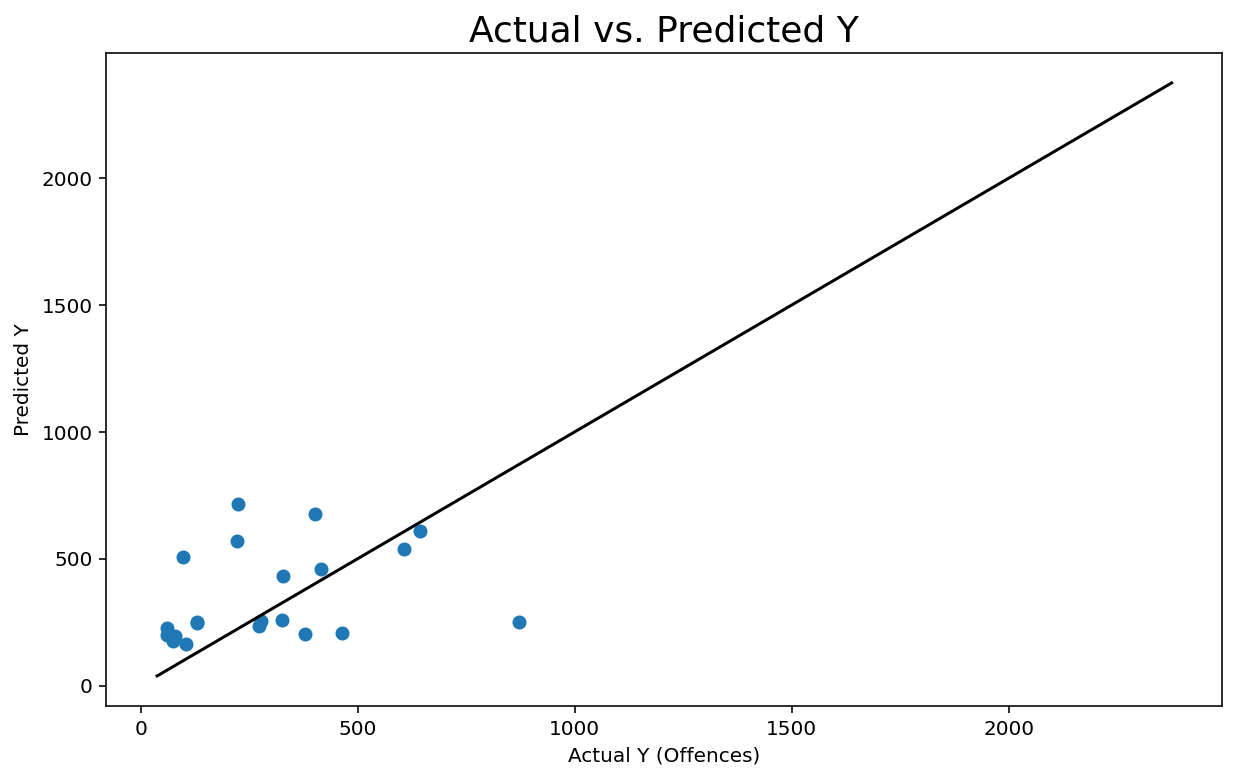

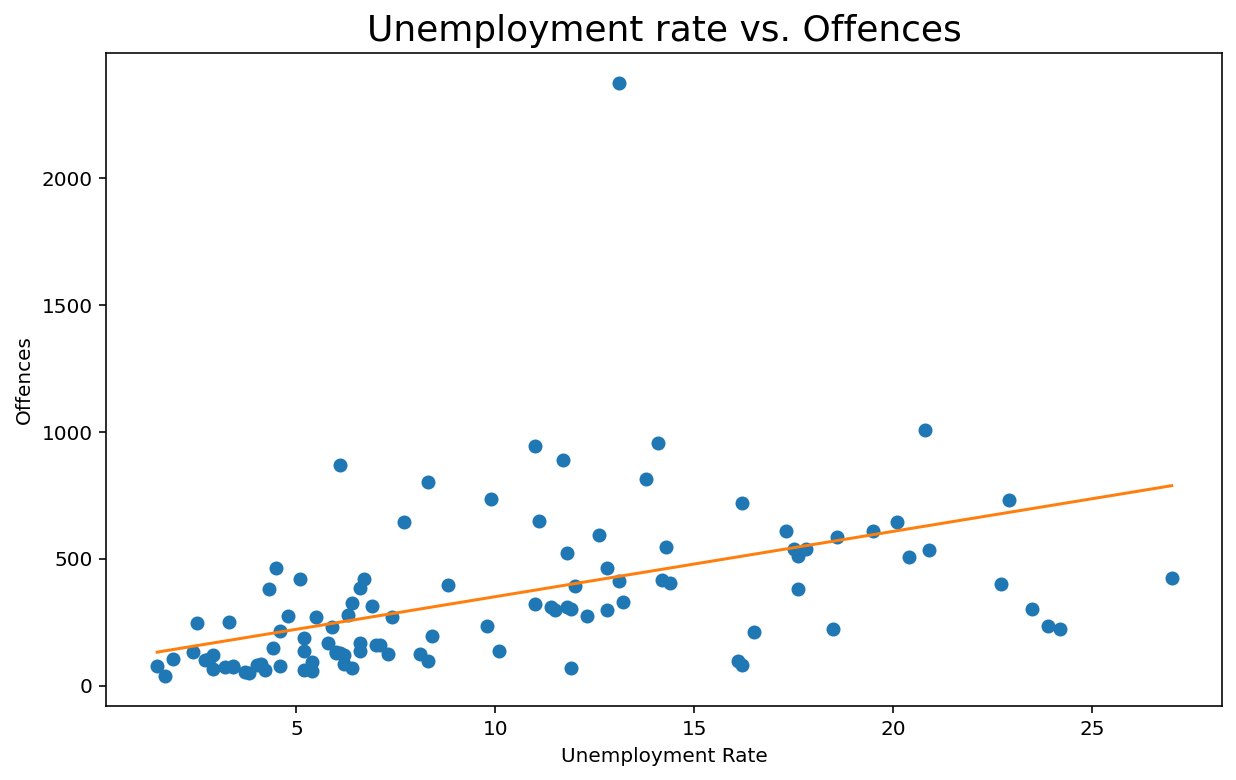

In [34]:
# Start with unemployment rate
y_train = np.array(train.offences)
x_train = np.array(train.unemploymentrate)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences)
x_test = np.array(test.unemploymentrate)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_2.offences), np.max(hague_2.offences), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_2.unemploymentrate, hague_2.offences, 'o')
xgrid = np.linspace(np.min(hague_2.unemploymentrate), np.max(hague_2.unemploymentrate), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("Unemployment Rate")
ax1.set_ylabel("Offences")
ax1.set_title('Unemployment rate vs. Offences', fontsize = 18)

Unemployment rate is not a good predictor of the number of offences in the neighborhood. However, there is a positive correlation between the two variables as I had hypothesized.

R^2 = -0.24162
0.19126941798298636
56794.2217483827
88465.88979978295
Coefficients: 
 -0.007763218575269364 698.4074795257541


Text(0.5, 1.0, 'Avg disposable income vs. Offences')

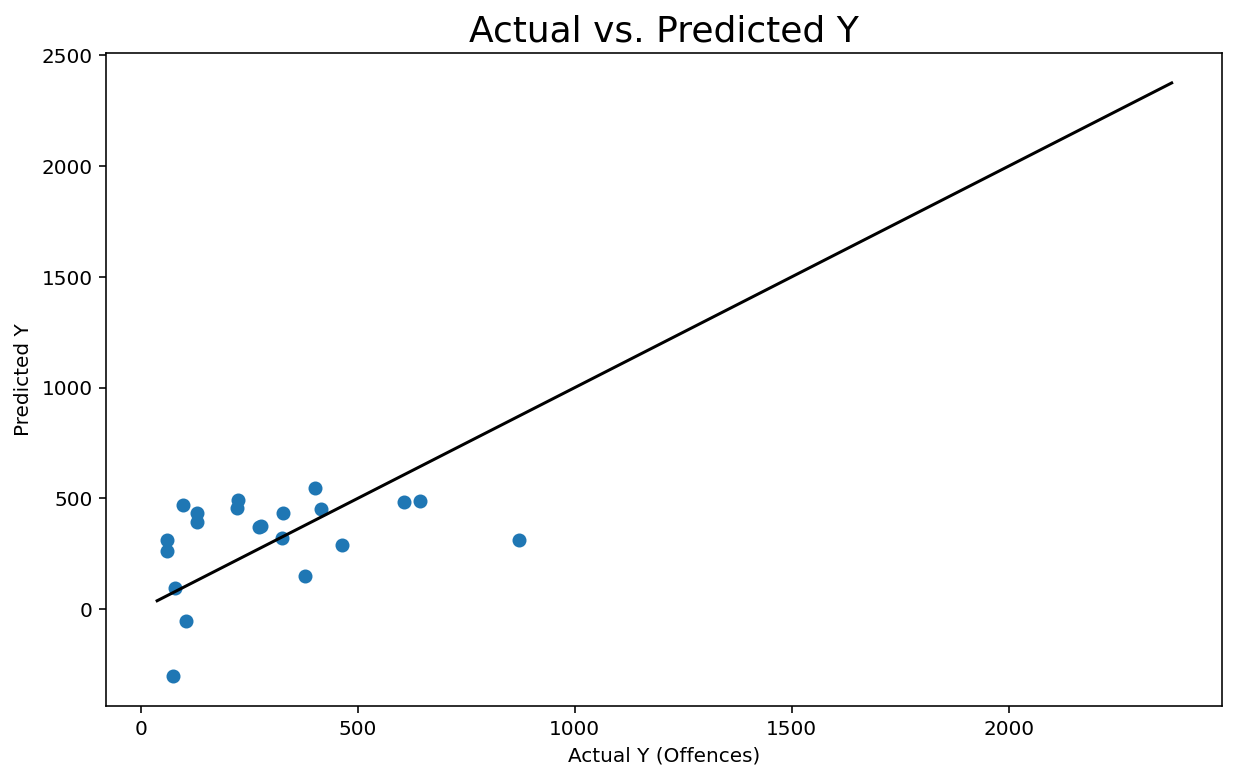

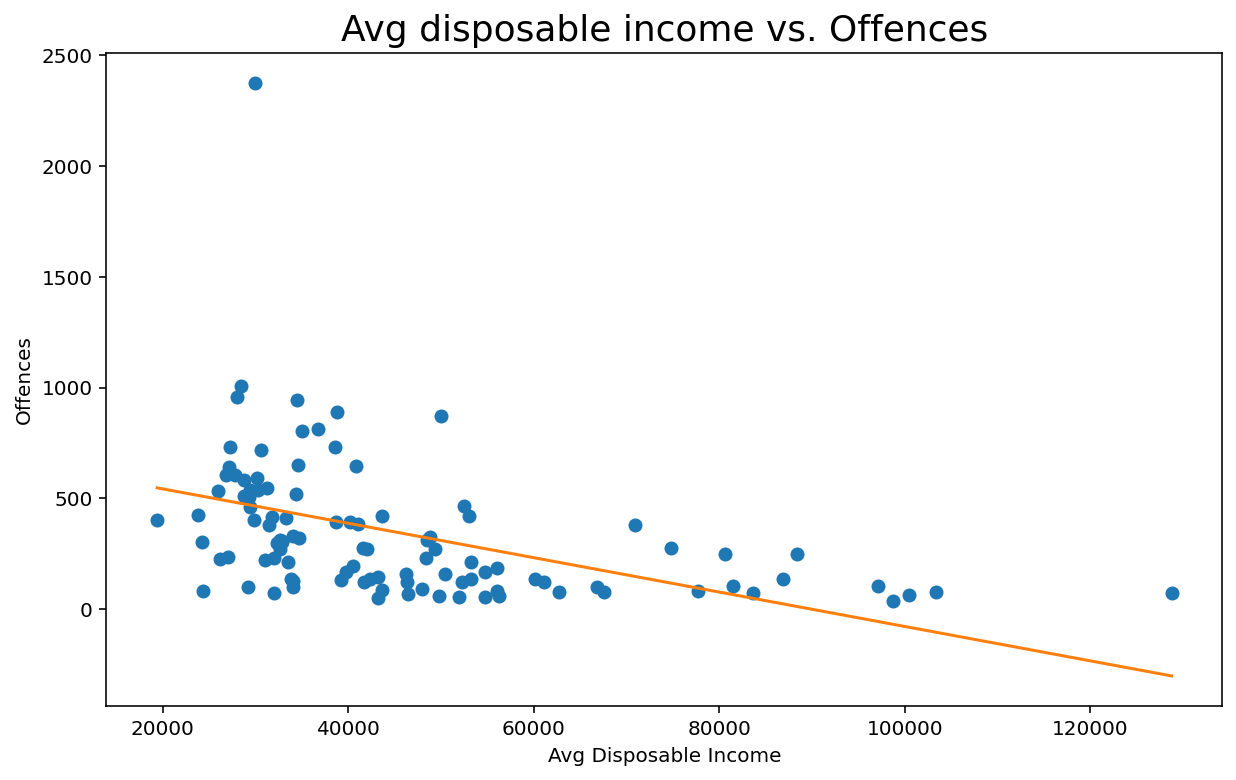

In [35]:
# Disposable Income
y_train = np.array(train.offences)
x_train = np.array(train.avgdisposableincome)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences)
x_test = np.array(test.avgdisposableincome)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_2.offences), np.max(hague_2.offences), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_2.avgdisposableincome, hague_2.offences, 'o')
xgrid = np.linspace(np.min(hague_2.avgdisposableincome), np.max(hague_2.avgdisposableincome), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("Avg Disposable Income")
ax1.set_ylabel("Offences")
ax1.set_title('Avg disposable income vs. Offences', fontsize = 18)

There is no correlation between avg disposable income and offences. However, there is a surprising relationship between the variables; the lower the avg disposable income, the lower the number of offences.

R^2 = 0.2073
0.20707875511093066
36259.69057657799
86736.52886393186
Coefficients: 
 6.58725062610714 159.46066336815102


Text(0.5, 1.0, '# of educational establishments vs. Offences')

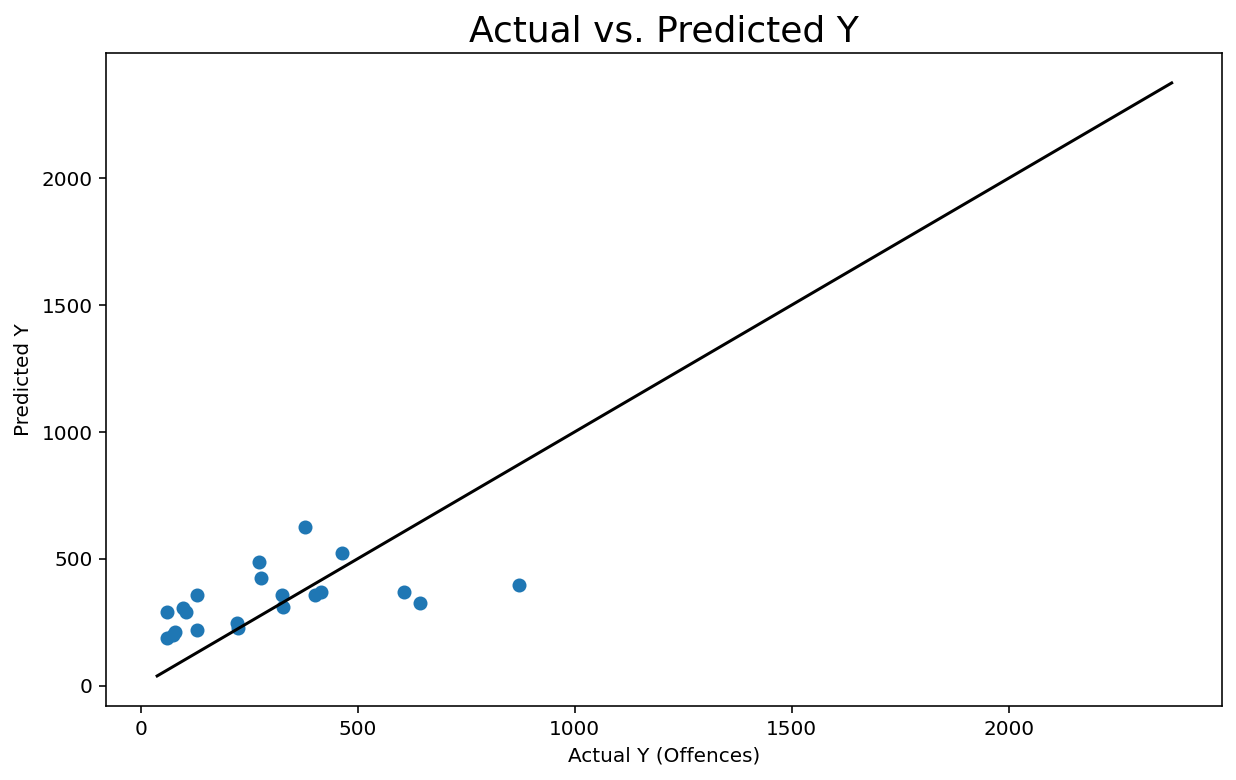

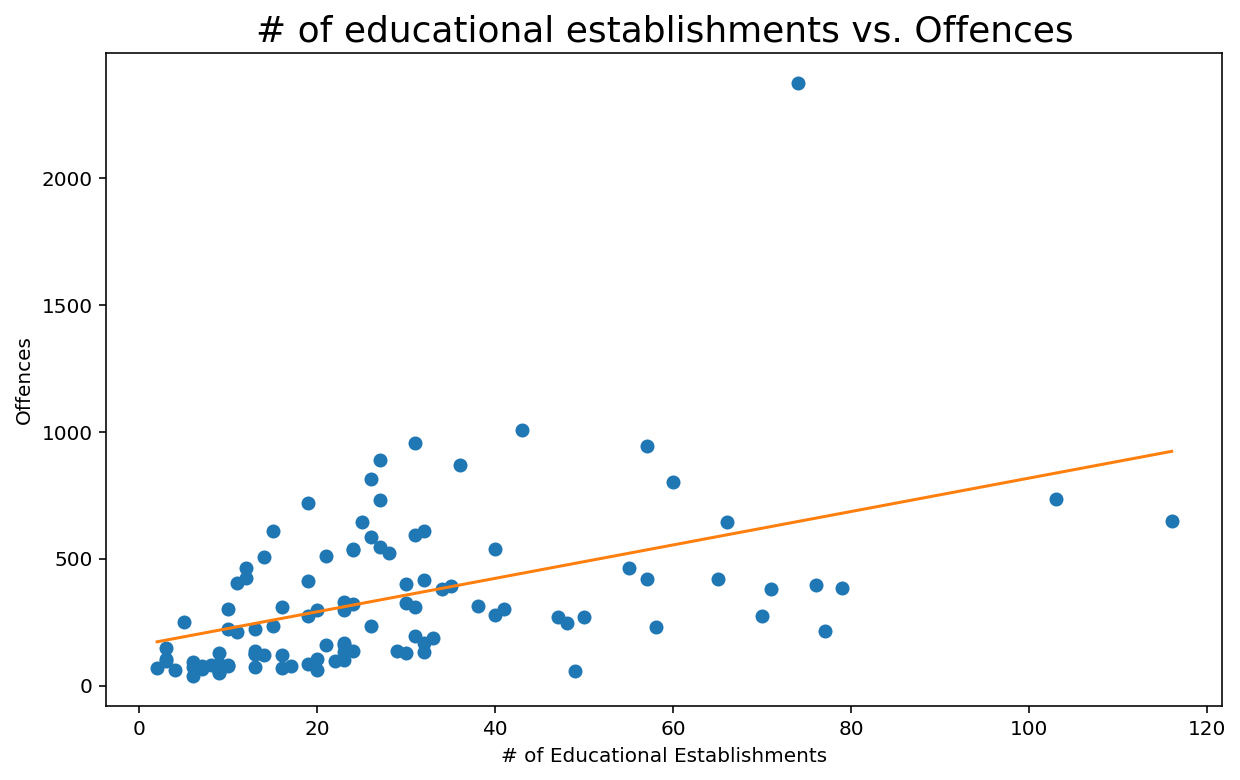

In [36]:
# Educational Establishments
y_train = np.array(train.offences)
x_train = np.array(train.educestablishments)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences)
x_test = np.array(test.educestablishments)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_2.offences), np.max(hague_2.offences), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_2.educestablishments, hague_2.offences, 'o')
xgrid = np.linspace(np.min(hague_2.educestablishments), np.max(hague_2.educestablishments), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("# of Educational Establishments")
ax1.set_ylabel("Offences")
ax1.set_title('# of educational establishments vs. Offences', fontsize = 18)

This relationship has a better R^2 value than the above two so they are slightly correlated. This model shows a surprising positive correlation between number of educational establishments and offences possibly due to the fact that with higher populated areas, there would be more educational establishments and therefore more potential for offences.

R^2 = 0.081924
0.23760766051696525
41994.682064165674
83397.01525901488
Coefficients: 
 -617.5111591270306 796.6574632457819


Text(0.5, 1.0, 'Avg private cars vs. Offences')

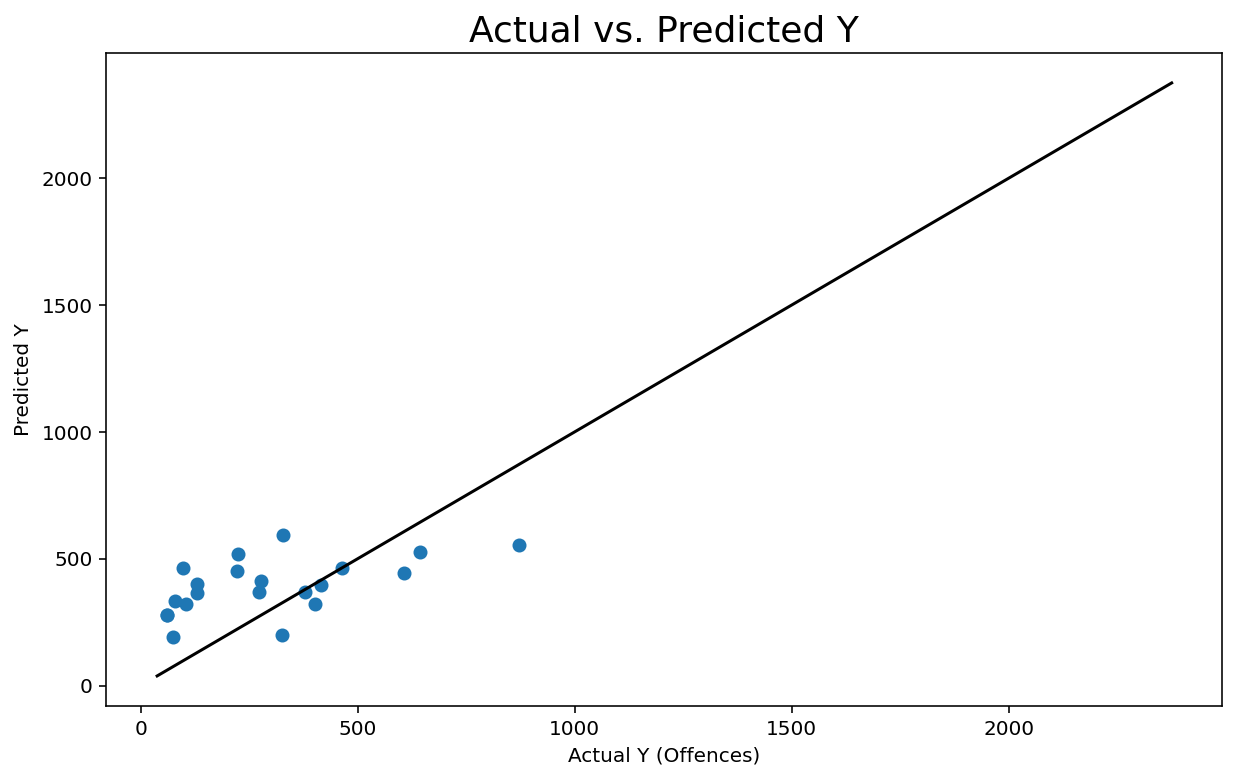

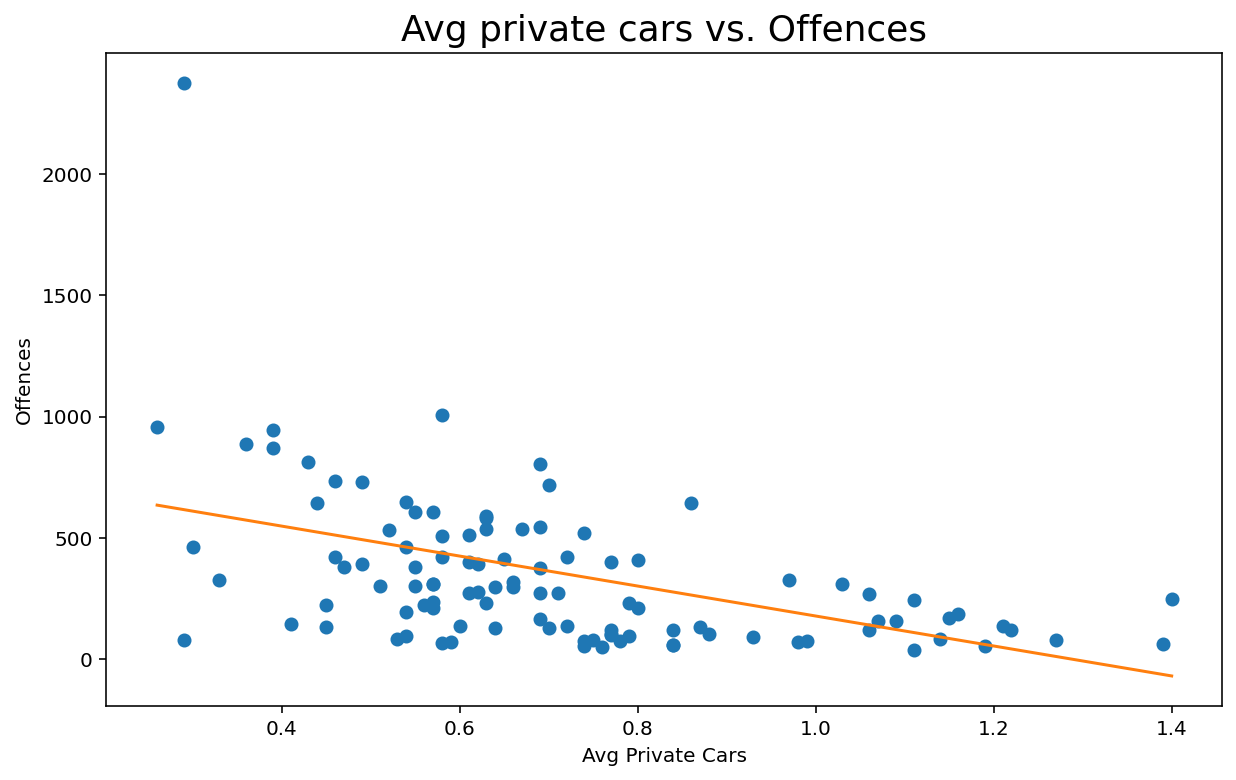

In [37]:
# Private cars
y_train = np.array(train.offences)
x_train = np.array(train.avgprivatecars)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences)
x_test = np.array(test.avgprivatecars)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_2.offences), np.max(hague_2.offences), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_2.avgprivatecars, hague_2.offences, 'o')
xgrid = np.linspace(np.min(hague_2.avgprivatecars), np.max(hague_2.avgprivatecars), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("Avg Private Cars")
ax1.set_ylabel("Offences")
ax1.set_title('Avg private cars vs. Offences', fontsize = 18)

There is no correlation between average private cars and number of offences, given the R^2 value.

R^2 = 0.48398
0.45832104118809913
23603.909561505745
59253.492006694854
Coefficients: 
 0.5952646083571784 25.05267135391847


Text(0.5, 1.0, '# of businesses/institutions vs. Offences')

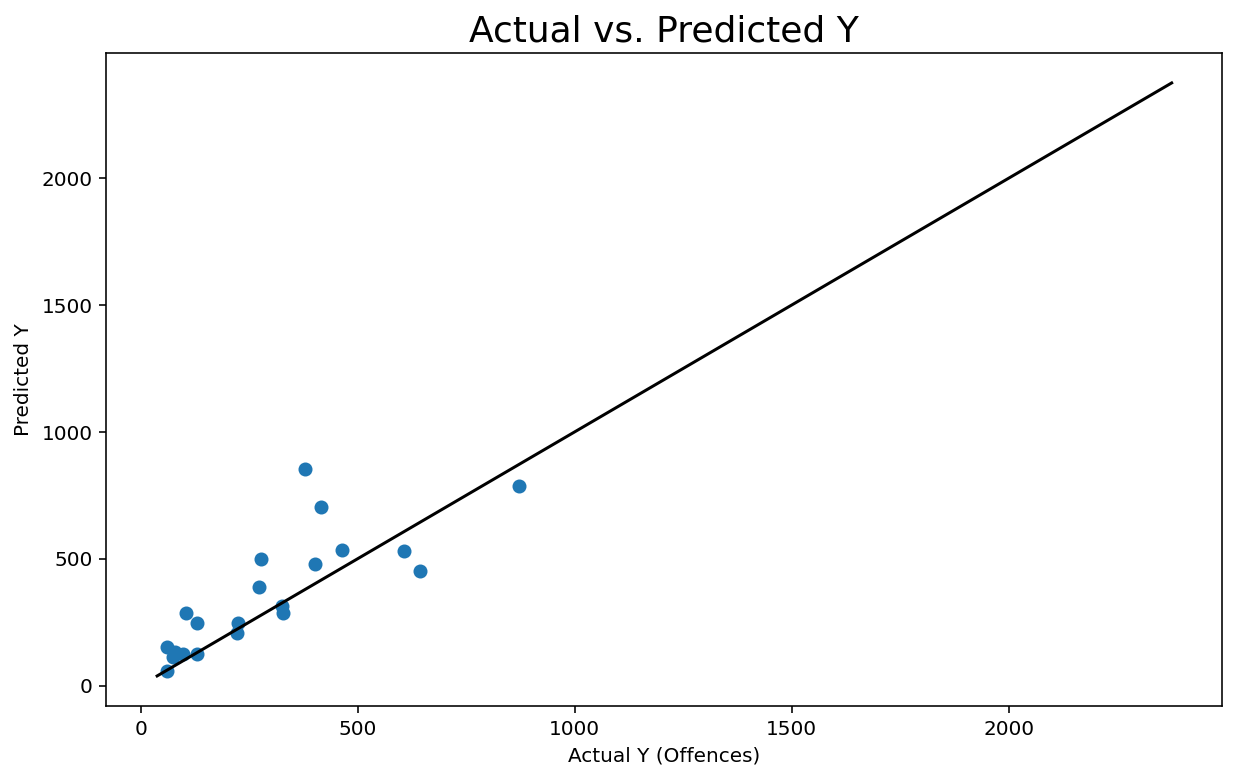

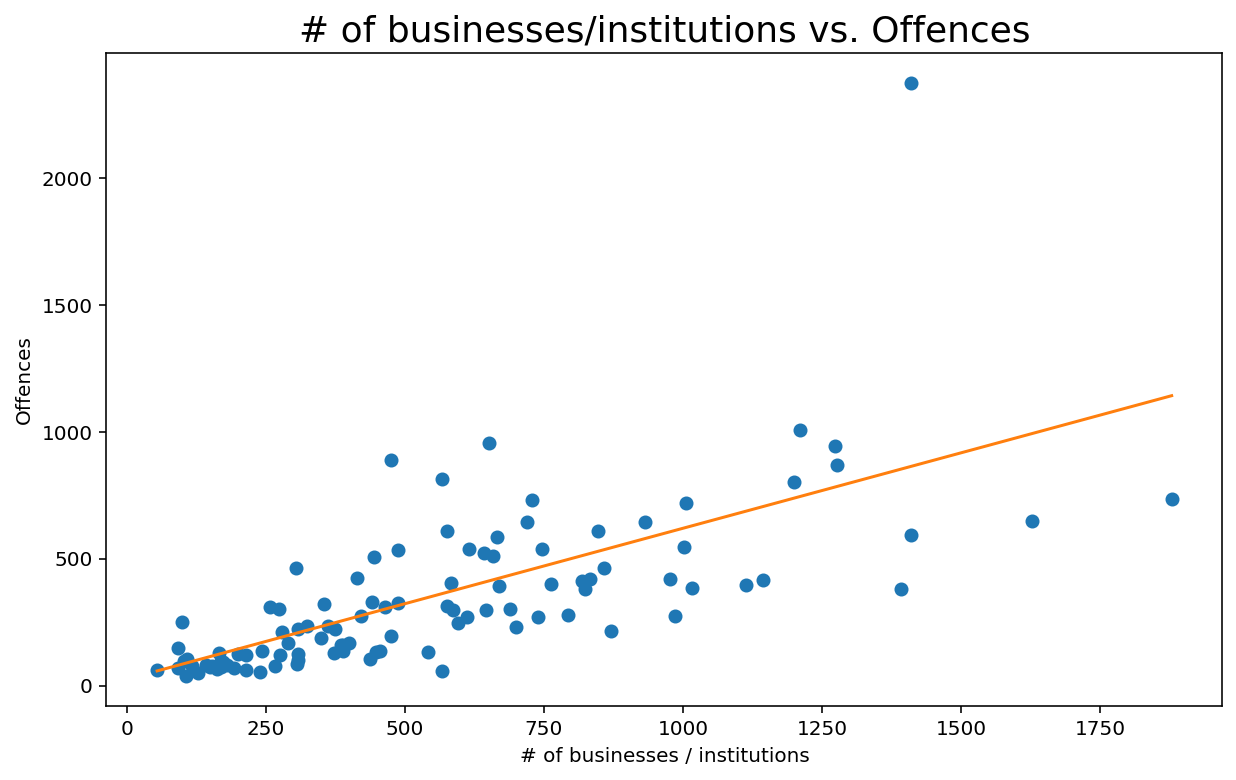

In [38]:
# Businesses
y_train = np.array(train.offences)
x_train = np.array(train.businesses)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences)
x_test = np.array(test.businesses)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_2.offences), np.max(hague_2.offences), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_2.businesses, hague_2.offences, 'o')
xgrid = np.linspace(np.min(hague_2.businesses), np.max(hague_2.businesses), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("# of businesses / institutions")
ax1.set_ylabel("Offences")
ax1.set_title('# of businesses/institutions vs. Offences', fontsize = 18)

The best correlation / predictor of offences out of the variables evaluated is the number of businesses / institutions. However, my hypothesis was wrong. The more businesses, the more offences. This is probably due to the fact that there is more opportunity for theft in areas with more businesses. 

To improve my model, I will use KNN to fill in the missing data that I had previously discarded. I realize that discarding data is not the best way to deal with missing pieces since there could be bias as to why there is no data for certain neighborhoods. I believe it is best to use KNN because I hypothesize that neighborhoods that are close together would have similar social demographic data.

## KNN to fill in missing data

In [220]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
hague.index.name = 'neighborhood'

In [221]:
# Replace missing values with NaN
hague['avgprivatecars'] = hague['avgprivatecars'].replace(['x'],'NaN')
hague['unemploymentrate'] = hague['unemploymentrate'].replace(['-'],'NaN')
hague.isna().sum()

neighb_cbs             0
geometry               0
unemploymentrate       0
educestablishments     0
avgdisposableincome    8
offences               0
avgprivatecars         2
businesses             0
dtype: int64

In [240]:
# Replace NaN values with 5 closest neighbors
hague_new = hague[['unemploymentrate', 'educestablishments', 'avgdisposableincome', 'offences', 'avgprivatecars', 'businesses']]
hague_array_withNaN = hague_new.values
hague_imputed = imputer.fit_transform(hague_array_withNaN)

In [223]:
# Convert imputed array back into dataframe and set index
hague_noNaN = pd.DataFrame({'unemploymentrate2': hague_imputed[:,0],'educestablishments2': hague_imputed[:,1],'avgdisposableincome2': hague_imputed[:,2],'offences2': hague_imputed[:,3],'avgprivatecars2': hague_imputed[:,4],'businesses2': hague_imputed[:,5]})
hague_noNaN['neighborhood'] = hague.index
hague_noNaN.set_index('neighborhood').head()

unemploymentrate2  educestablishments2  avgdisposableincome2  offences2  avgprivatecars2  businesses2
neighborhood                                                                                                           
70 Oostduinen                  6.62                  0.0               64900.0       43.0            0.822         10.0
71 Belgisch Park               5.10                 65.0               53000.0      422.0            0.720        977.0
73 Westbroekpark               1.90                  3.0               81500.0      103.0            0.880        108.0
74 Duttendel                   3.20                  6.0              128800.0       74.0            0.980        150.0
48 Nassaubuurt                 2.80                 20.0               97100.0      104.0            0.770        438.0

In [241]:
# Merge KNN imputed data with existing master Hague dataframe
hague_new = pd.merge(hague, hague_noNaN, on='neighborhood').set_index('neighborhood')
hague_new = hague_new[['geometry', 'unemploymentrate2', 'educestablishments2', 'avgdisposableincome2', 'offences2', 'avgprivatecars2', 'businesses2']]
hague_new.head()

geometry  unemploymentrate2  educestablishments2  avgdisposableincome2  offences2  avgprivatecars2  businesses2
neighborhood                                                                                                                                                              
70 Oostduinen     POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...               6.62                  0.0               64900.0       43.0            0.822         10.0
71 Belgisch Park  POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...               5.10                 65.0               53000.0      422.0            0.720        977.0
73 Westbroekpark  POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...               1.90                  3.0               81500.0      103.0            0.880        108.0
74 Duttendel      POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...               3.20                  6.0              128800.0       74.0            0.980        150.0
48 Nassaubuurt    POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...               2.80                 20.0               97100.0      104.0            0.770        438.0

## Linear Regression with new dataframe containing filled KNN to missing data

In [44]:
# Testing set is set to 20% of the total data; training set is set to 80%
train, test = train_test_split(hague_new, test_size=0.2, random_state=42)

R^2 = -0.1266
0.18907293182698437
37515.736445923525
87813.87286975255
Coefficients: 
 22.918821099922173 106.35533309895237


Text(0.5, 1.0, 'Unemployment rate vs. Offences')

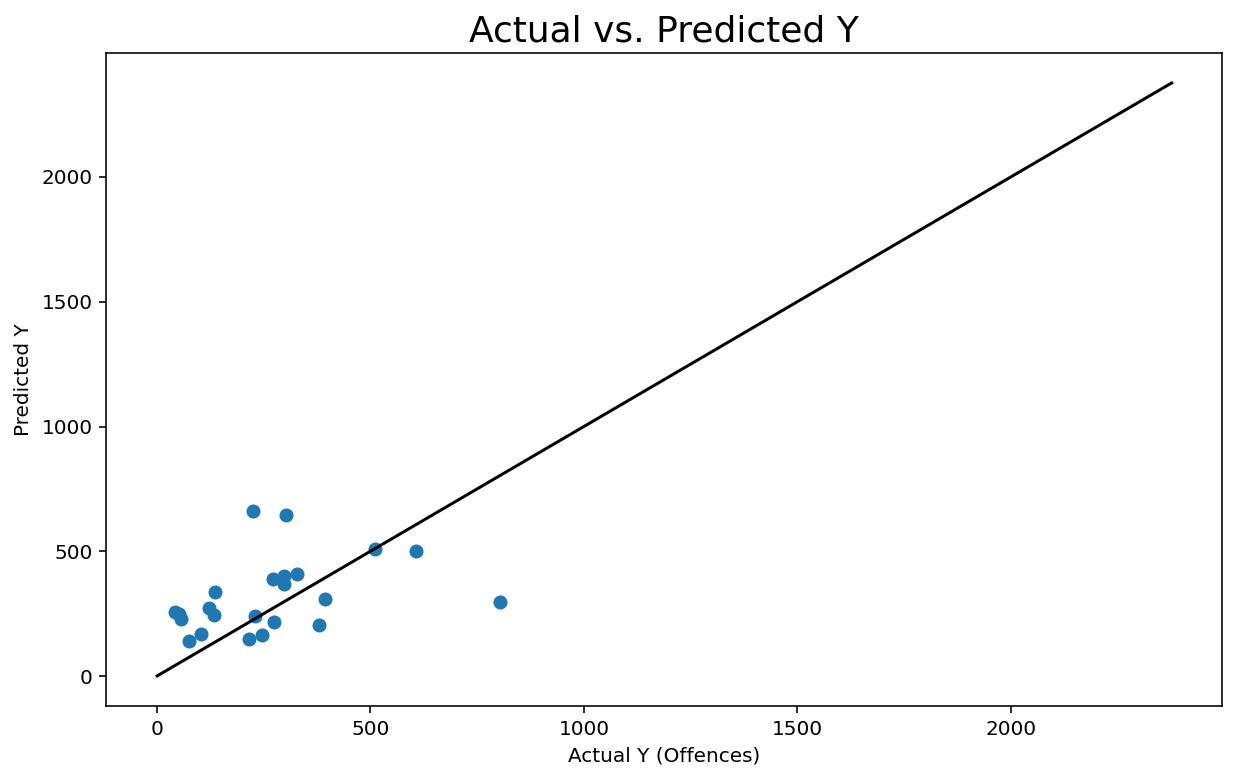

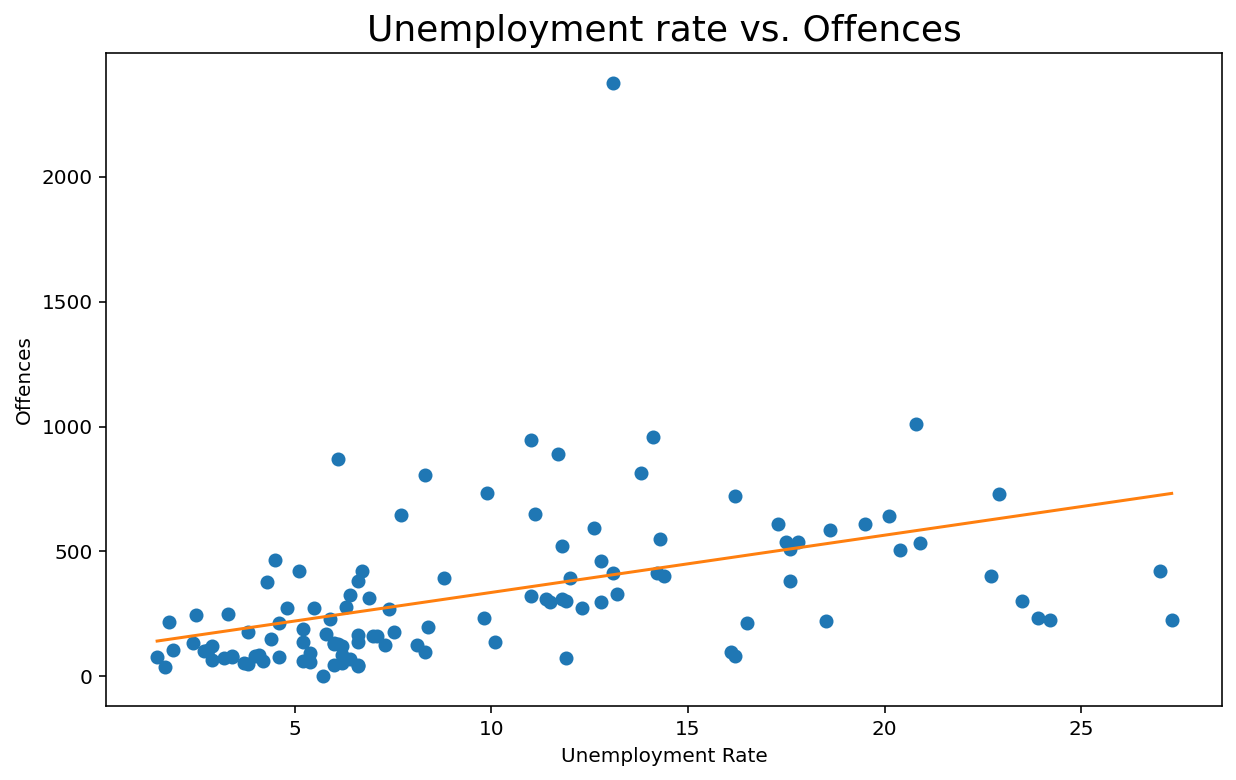

In [45]:
# Unemployment rate
y_train = np.array(train.offences2)
x_train = np.array(train.unemploymentrate2)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences2)
x_test = np.array(test.unemploymentrate2)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_new.offences2), np.max(hague_new.offences2), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_new.unemploymentrate2, hague_new.offences2, 'o')
xgrid = np.linspace(np.min(hague_new.unemploymentrate2), np.max(hague_new.unemploymentrate2), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("Unemployment Rate")
ax1.set_ylabel("Offences")
ax1.set_title('Unemployment rate vs. Offences', fontsize = 18)

The R^2 value is slightly better, though there is still no correlation.

R^2 = -0.11191
0.18445956866377466
37026.6378247269
88313.44589205751
Coefficients: 
 -0.007370540587004175 669.128341933727


Text(0.5, 1.0, 'Average disposable income vs. Offences')

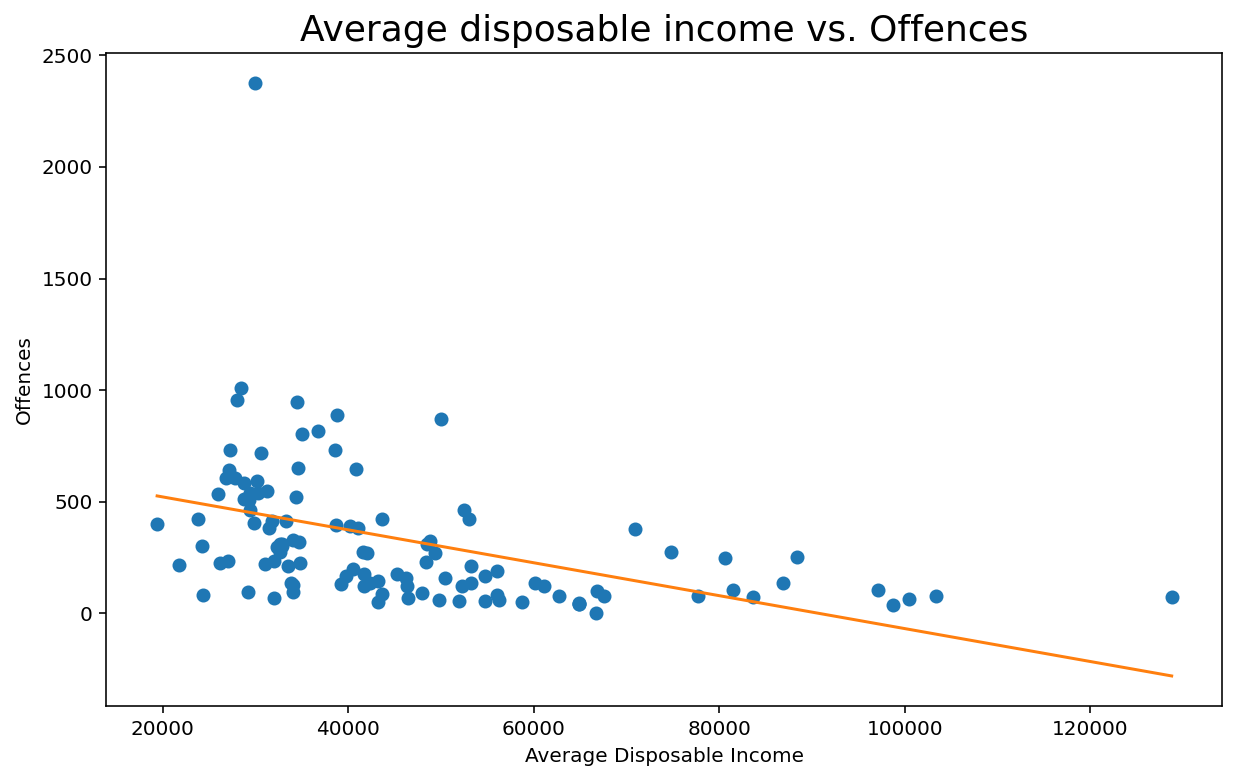

In [46]:
# Average Disposable Income
y_train = np.array(train.offences2)
x_train = np.array(train.avgdisposableincome2)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences2)
x_test = np.array(test.avgdisposableincome2)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_new.offences2), np.max(hague_new.offences2), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_new.avgdisposableincome2, hague_new.offences2, 'o')
xgrid = np.linspace(np.min(hague_new.avgdisposableincome2), np.max(hague_new.avgdisposableincome2), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("Average Disposable Income")
ax1.set_ylabel("Offences")
ax1.set_title('Average disposable income vs. Offences', fontsize = 18)

Again, the R^2 improved but it is still negative.

R^2 = -0.31644
0.2639631931268581
43837.498245862684
79704.13755189466
Coefficients: 
 -678.8566683064427 825.0850200847649


Text(0.5, 1.0, 'Average private cars vs. Offences')

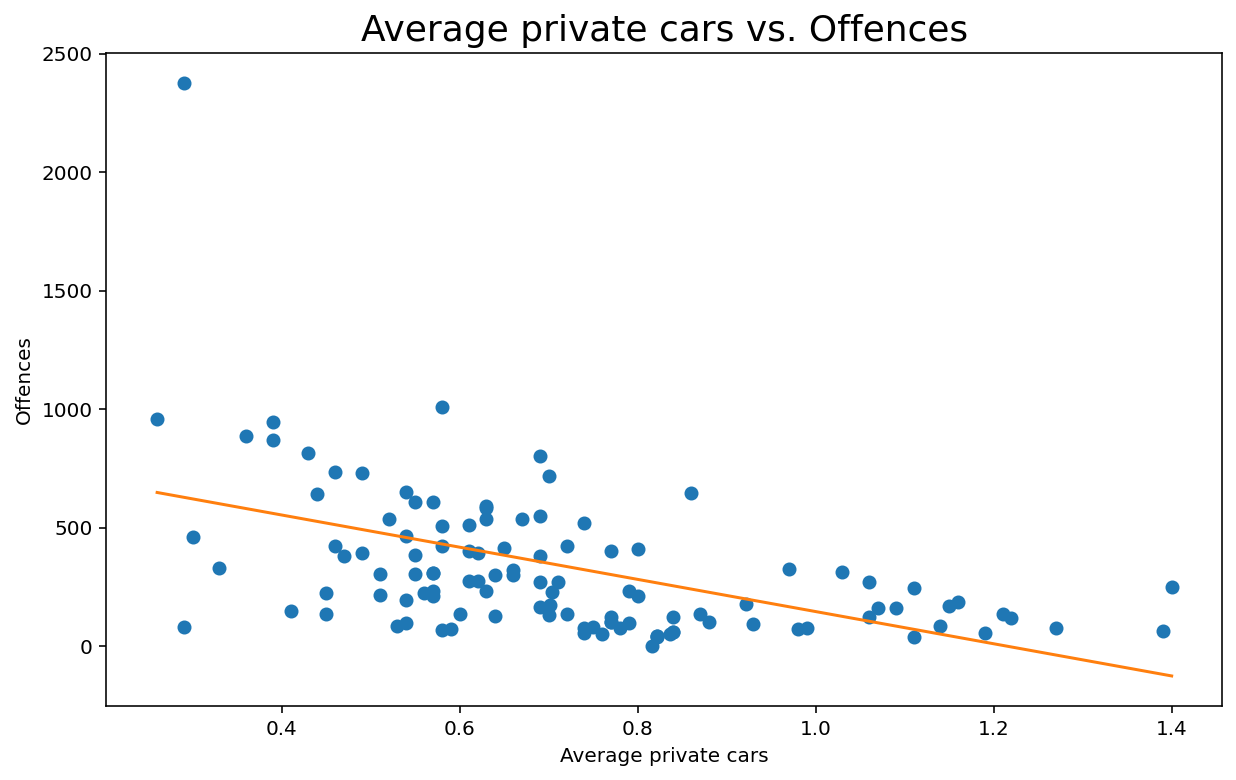

In [47]:
# Average Private Cars
y_train = np.array(train.offences2)
x_train = np.array(train.avgprivatecars2)
x_train = x_train.reshape(x_train.shape[0], 1)

y_test = np.array(test.offences2)
x_test = np.array(test.avgprivatecars2)
x_test = x_test.reshape(x_test.shape[0], 1)

# Create and fit linear model
regression = LinearRegression()
regression.fit(x_train, y_train)
predicted_y = regression.predict(x_test)
r2 = regression.score(x_test, y_test)
print(f'R^2 = {r2:.5}')
print(regression.score(x_train, y_train))
print(mean_squared_error(predicted_y, y_test))
print(mean_squared_error(y_train, regression.predict(x_train)))
print('Coefficients: \n', regression.coef_[0], regression.intercept_)

# Plot model
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, 'o')
grid = np.linspace(np.min(hague_new.offences2), np.max(hague_new.offences2), 100)
ax.plot(grid, grid, color="black") # 45 degree line
ax.set_xlabel("Actual Y (Offences)")
ax.set_ylabel("Predicted Y")
ax.set_title('Actual vs. Predicted Y', fontsize = 18)

# Plot linear regression
fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(hague_new.avgprivatecars2, hague_new.offences2, 'o')
xgrid = np.linspace(np.min(hague_new.avgprivatecars2), np.max(hague_new.avgprivatecars2), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
ax1.set_xlabel("Average private cars")
ax1.set_ylabel("Offences")
ax1.set_title('Average private cars vs. Offences', fontsize = 18)

The R^2 value worsened after filling in missing data with KNN. This further proves there is no correlation.

Because there is no good linear fit, this suggests that the relationship between the variables and number of offences is not linear. To improve the model, other forms of fit can be tested like logarithmic or exponential to see if that would be a better fit. Also, the linear fit assumes that there is only one variable that could predict crime at a time when in reality it could be a multiplicity of variables together that would be a better predictor. A model that takes into account two or three or more variables as a predictor would further improve the model.

With this analyses, the strengths and weaknesses of linear regression is apparent. It is easy to implement to get a quick idea of the relationship between variables. However, it is not appropriate for non-linear relationships and can only show relationship between two variables at a time. It also is not very realistic as most things in reality are not related in a perfectly linear way.

## K-Means Clustering Model

In [225]:
kmeans5 = cluster.KMeans(n_clusters=5)
np.random.seed(1234)
hague_new_data = hague_new[['unemploymentrate2', 'educestablishments2', 'avgdisposableincome2', 'offences2', 'avgprivatecars2', 'businesses2']]
k5cls = kmeans5.fit(hague_new_data)
k5cls.labels_

array([3, 0, 4, 1, 1, 0, 3, 4, 4, 3, 4, 1, 2, 0, 0, 0, 0, 2, 3, 0, 4, 0,
       0, 0, 0, 0, 4, 3, 0, 4, 3, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2,
       2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 3, 0, 0, 3, 0, 3, 1, 3, 0, 0, 0, 0, 3, 3, 0,
       3, 3, 3, 3])

In [226]:
# Append to original dataframe
hague_new['k5cls'] = k5cls.labels_
hague_new.head()

geometry  unemploymentrate2  educestablishments2  avgdisposableincome2  offences2  avgprivatecars2  businesses2  k5cls
neighborhood                                                                                                                                                                     
70 Oostduinen     POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...               6.62                  0.0               64900.0       43.0            0.822         10.0      3
71 Belgisch Park  POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...               5.10                 65.0               53000.0      422.0            0.720        977.0      0
73 Westbroekpark  POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...               1.90                  3.0               81500.0      103.0            0.880        108.0      4
74 Duttendel      POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...               3.20                  6.0              128800.0       74.0            0.980        150.0      1
48 Nassaubuurt    POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...               2.80                 20.0               97100.0      104.0            0.770        438.0      1

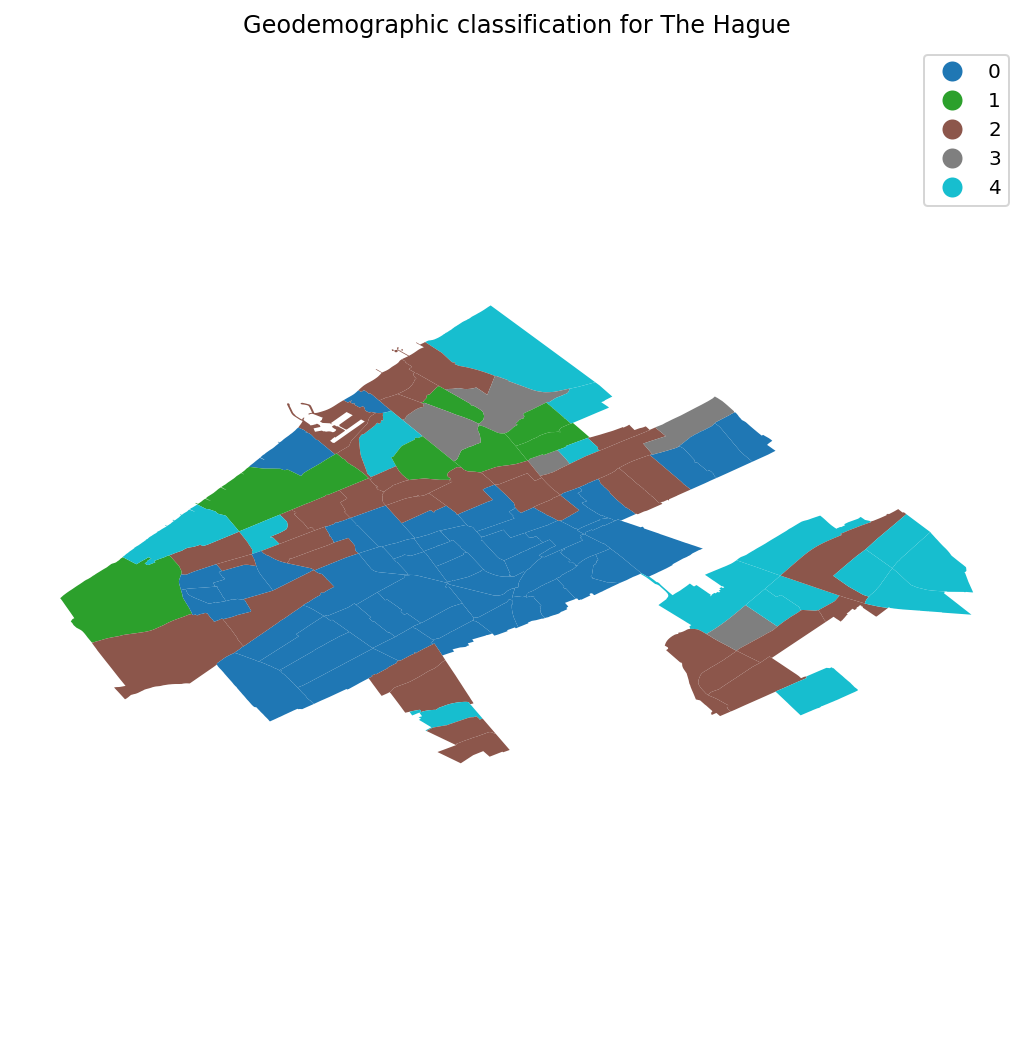

In [50]:
# Plot the choropleth
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot unique values choropleth with legend
hague_new.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)

# Customize axes
ax.set_axis_off()
plt.axis('equal')

# Add title
plt.title('Geodemographic classification for The Hague')
plt.show()

There are a lot of observations for group 0 which are mainly in the center and south side of the Hague. Group 1 is primarily near the coast. Group 2 is spread out around the city center. Group 3 has very few observations mainly in the North side. Group 4 is also spread out both by the coast and on the East side.

k5cls
0    50
1     7
2    36
3     5
4    16
dtype: int64


Text(0.5, 1.0, '# of observations per cluster')

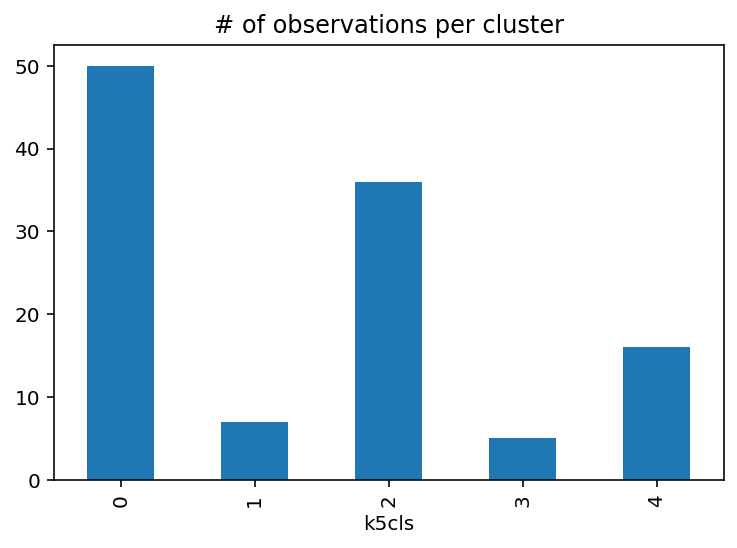

In [51]:
print(hague_new.groupby('k5cls').size())
plot = hague_new.groupby('k5cls').size().plot.bar()
plot.set_title('# of observations per cluster')

In [52]:
# Drop geometry column
hague_new2 = hague_new.drop(columns='geometry')

# Set up plot data
plot = hague_new2.set_index('k5cls')
plot = plot.stack()
plot = plot.reset_index()
plot = plot.rename(columns={'level_1': 'Variable', 0: 'Values'})
plot.head()

k5cls              Variable     Values
0      4     unemploymentrate2      6.620
1      4   educestablishments2      0.000
2      4  avgdisposableincome2  64900.000
3      4             offences2     43.000
4      4       avgprivatecars2      0.822

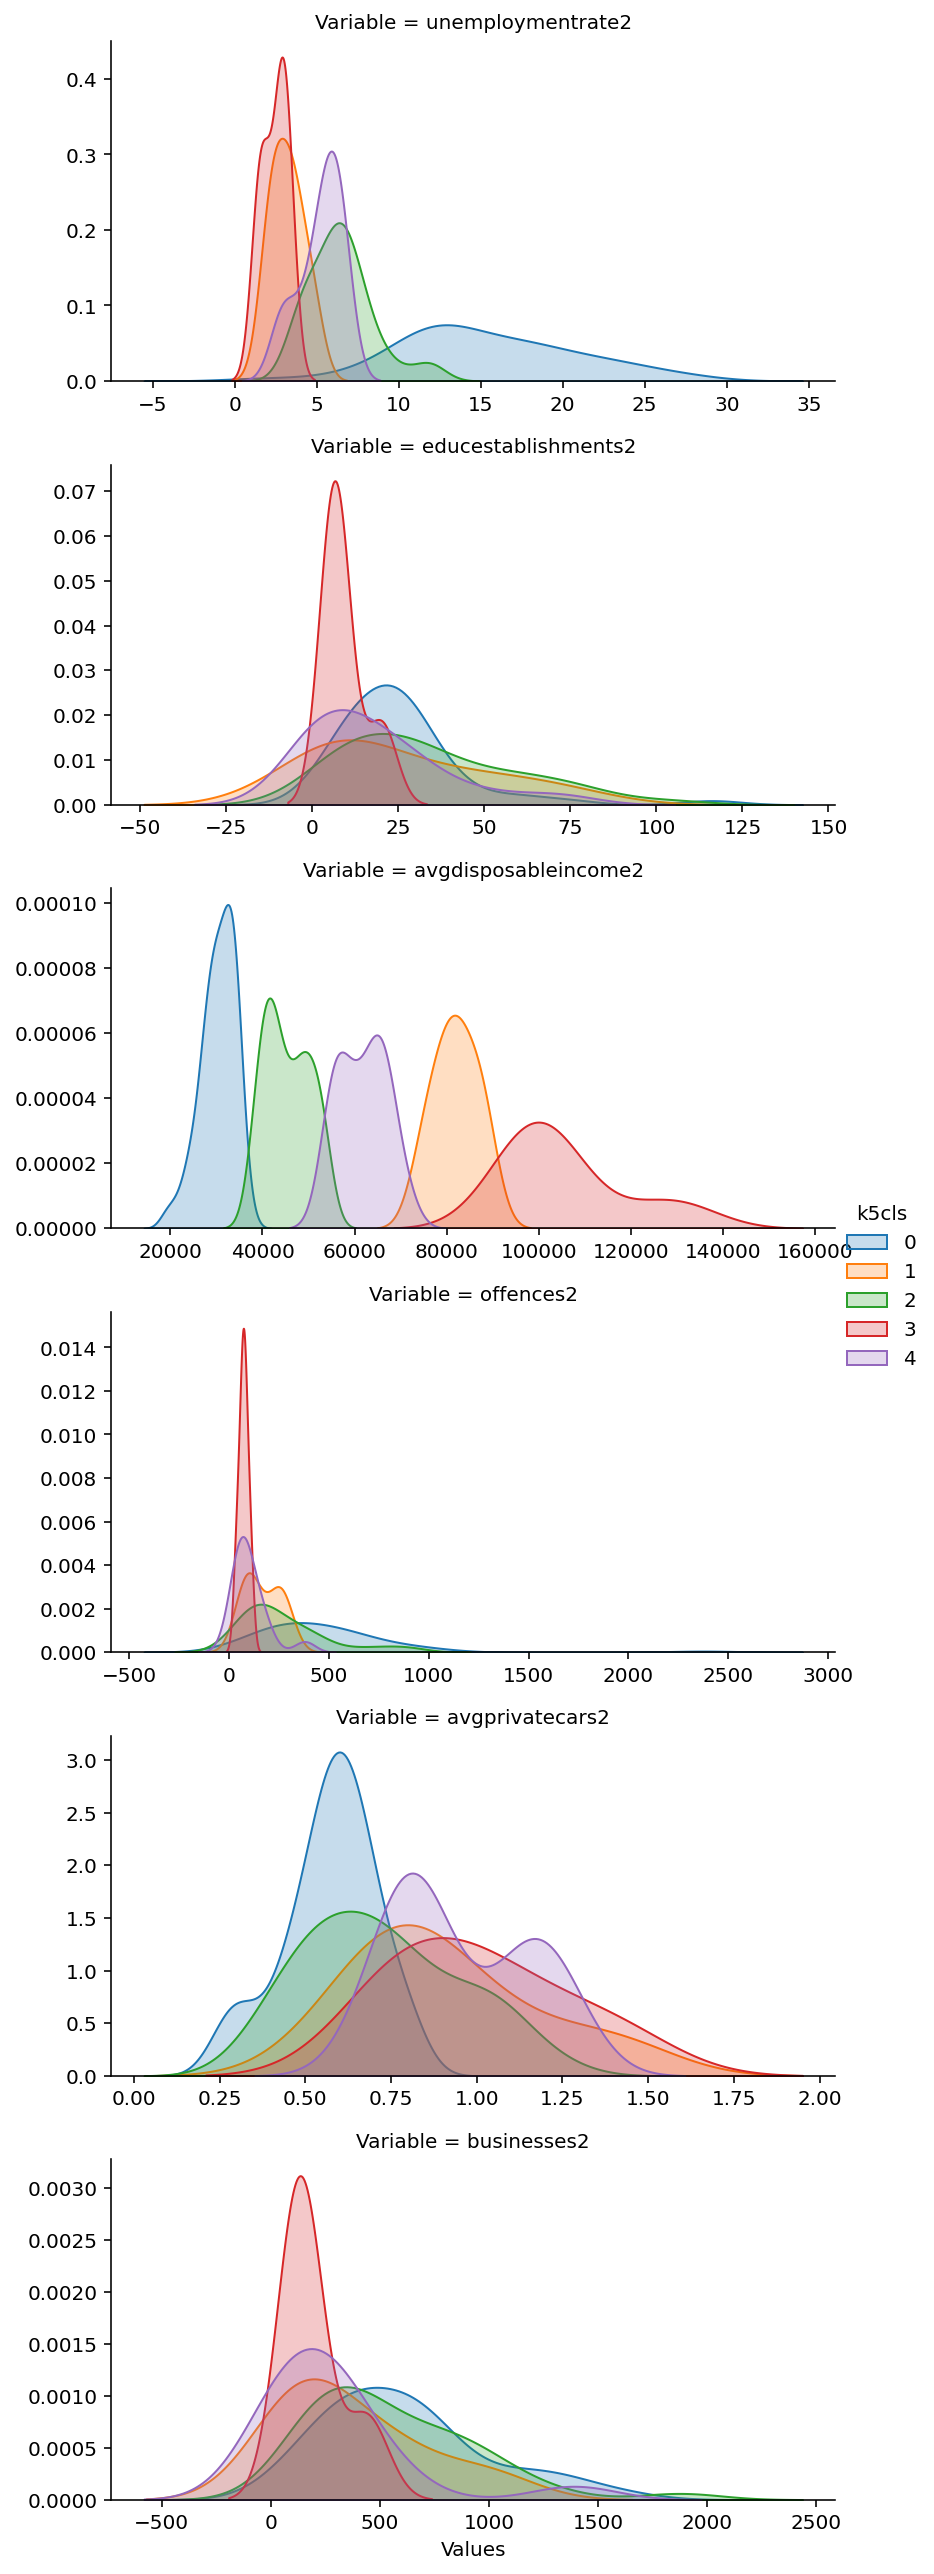

In [53]:
# Set up facets and plot
facets = sns.FacetGrid(data=plot, row='Variable', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2)
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

The clustering model is a better model to see how the various variables under study in this report are distributed across The Hague. The key strength of this model is that it is easy to categorize and get a sense of a large data set with multiple variables quickly. However, it doesn't take into account the impact of outliers within the variables when it clusters which could skew the groupings.

To improve the model, various k's can be tested to see which is the optimal k. In this case, it was easy to cluster since I filled in missing data using KNN. It would be an extra improvement if clustering can take into account different data sizes to take into account missing data. It should also be able to adjust for outliers. 

To have more specific analyses, I will now use regionalization to constrain classification spatially.

## Regionalization

In [242]:
# Create regions
w = weights.Queen.from_dataframe(hague_new)
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)
np.random.seed(123)
sagg13cls = sagg13.fit(hague_new_data)
hague_new['sagg13cls'] = sagg13cls.labels_
hague_new.head()

geometry  unemploymentrate2  educestablishments2  avgdisposableincome2  offences2  avgprivatecars2  businesses2  sagg13cls
neighborhood                                                                                                                                                                         
70 Oostduinen     POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...               6.62                  0.0               64900.0       43.0            0.822         10.0         10
71 Belgisch Park  POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...               5.10                 65.0               53000.0      422.0            0.720        977.0         10
73 Westbroekpark  POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...               1.90                  3.0               81500.0      103.0            0.880        108.0          0
74 Duttendel      POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...               3.20                  6.0              128800.0       74.0            0.980        150.0          8
48 Nassaubuurt    POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...               2.80                 20.0               97100.0      104.0            0.770        438.0          0

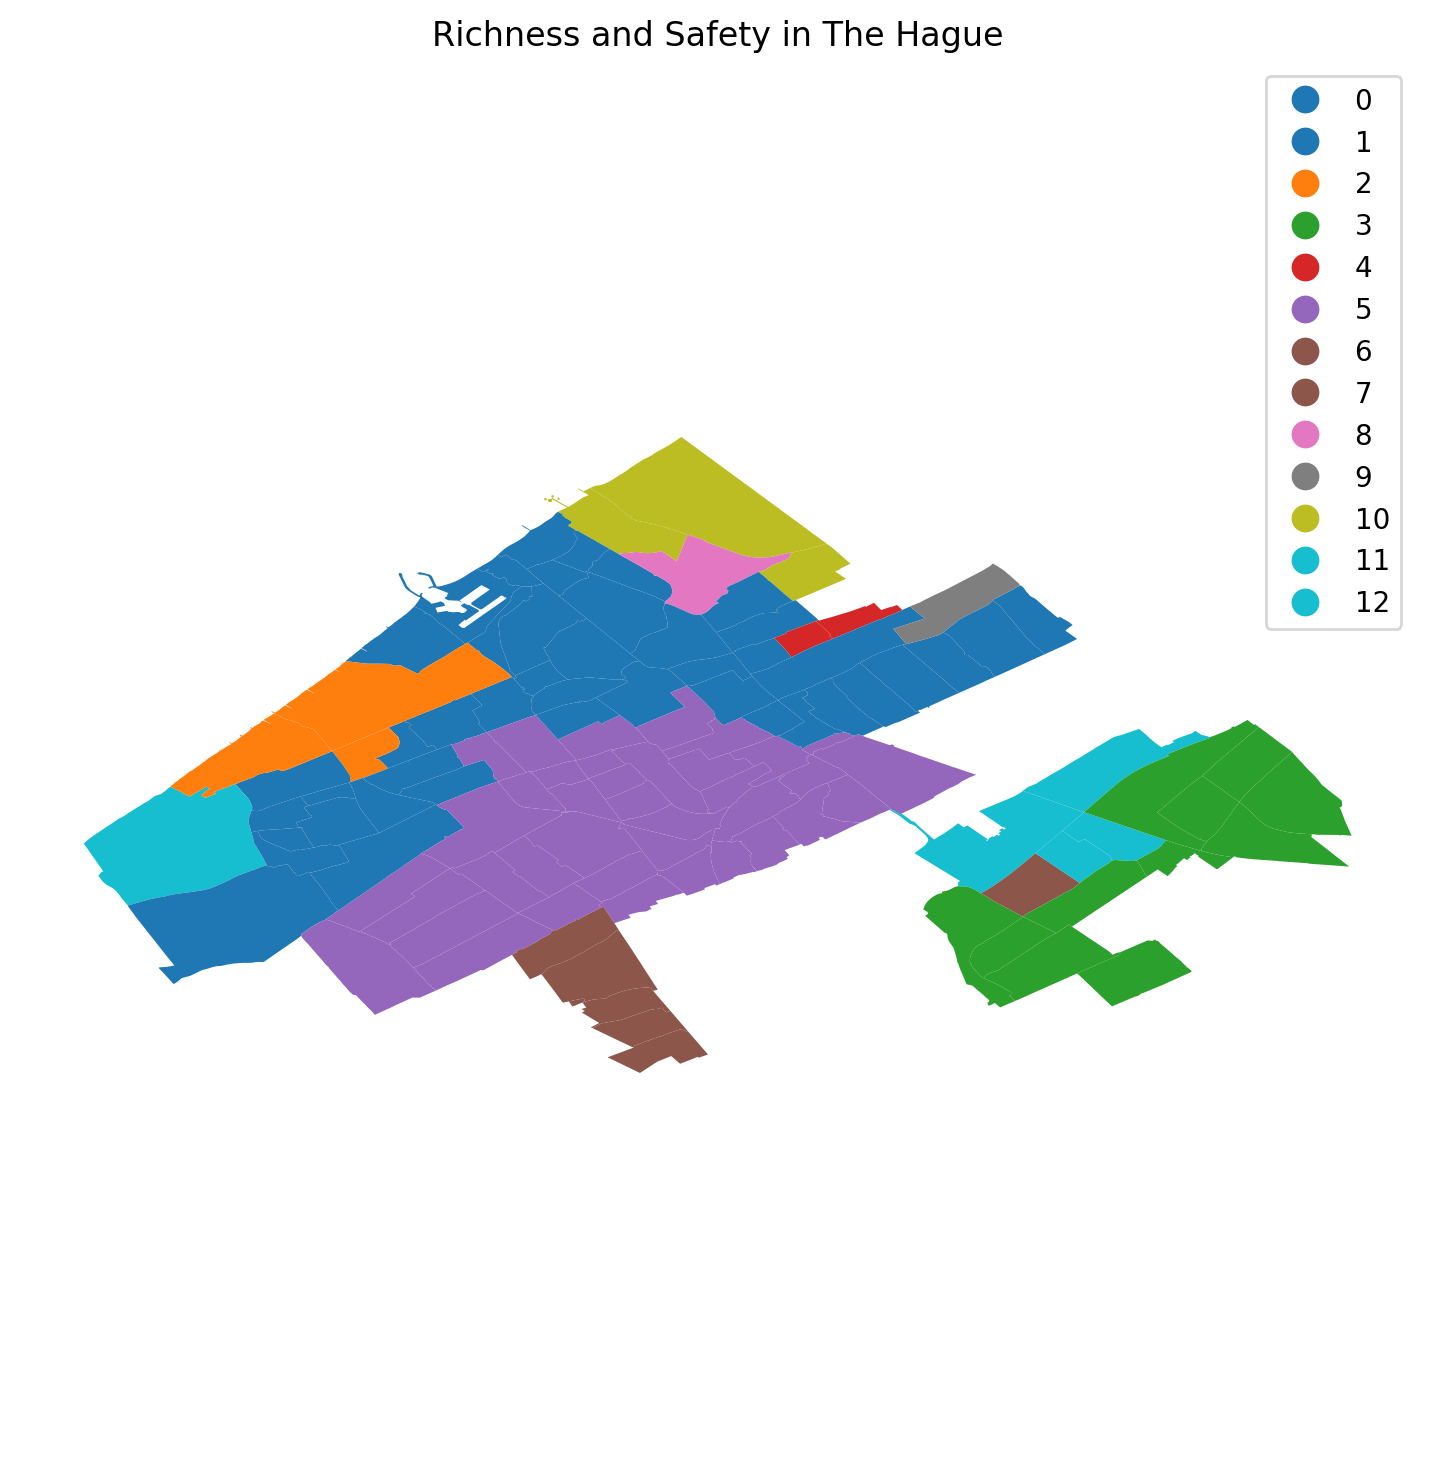

In [33]:
# Map regions
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot unique values choropleth with legend
hague_new.plot(column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax)

# Customize axes
ax.set_axis_off()
plt.axis('equal')

# Add title
plt.title('Richness and Safety in The Hague')
plt.show()

In [56]:
# Create new regions
def dissolve(gs):
    return gs.unary_union

# Dissolve polygons based on regionalization
hague_regions = gpd.GeoSeries(hague_new.groupby(hague_new['sagg13cls']).apply(dissolve),crs=hague_new.crs)

# Plot new regions
f, ax = plt.subplots(1, figsize=(6, 6))

# Plot boundary lines
hague_regions.plot(ax=ax, linewidth=0.5, facecolor='white', edgecolor='k')
# Customize axes
ax.set_axis_off()
plt.axis('equal')

# Add title
plt.title('Safety and Richness Regions in The Hague')
plt.show()

The strength of this model is that policymakers can better target areas within The Hague that have similar characteristics. It is more spatially conscious. For The Hague, there were enough neighborhoods for regionalization. A potential weakness for this model is in smaller urban areas that have a smaller sample size may find it tough to have adequate regionalization done. 

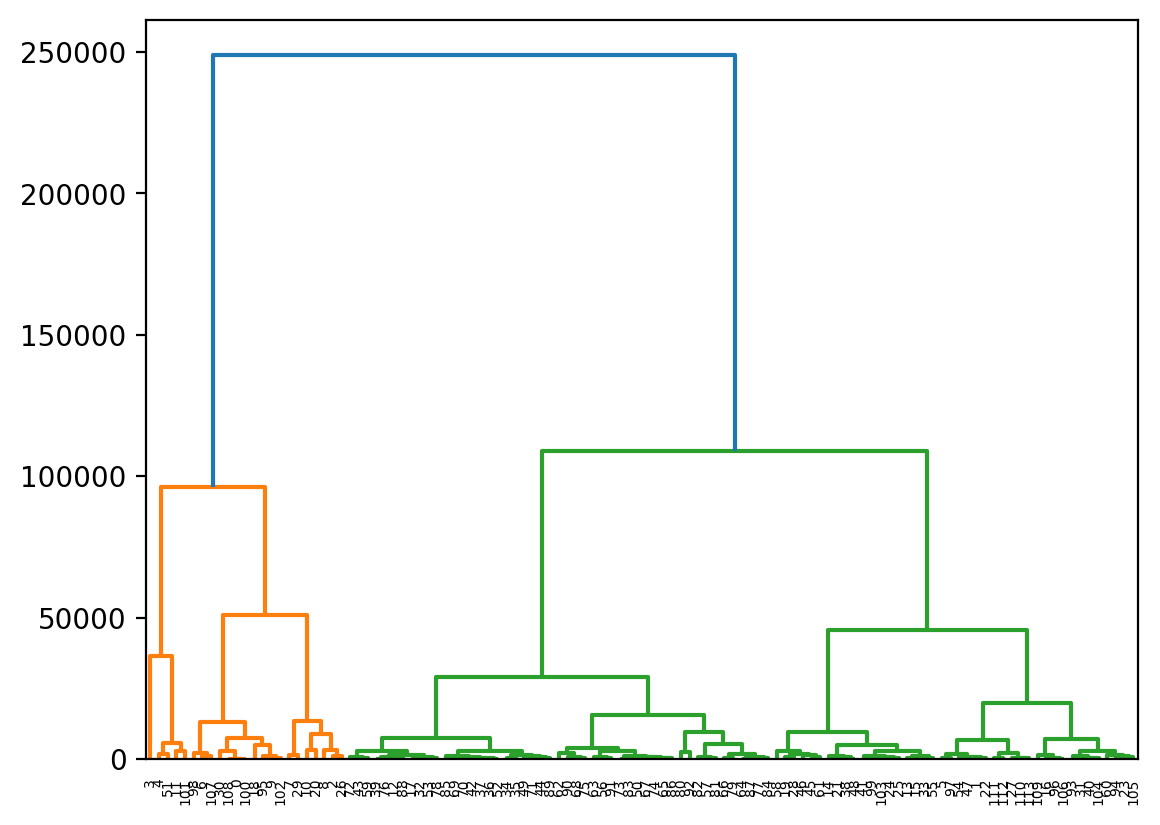

In [228]:
# Create or load spatial weights matrix
w = weights.Queen.from_dataframe(hague_new)

# Calculate linkage matrix
linkage_matrix = linkage(hague_new_data, method='ward', metric='euclidean')

# Plot dendrogram
dendrogram(linkage_matrix)
plt.show()

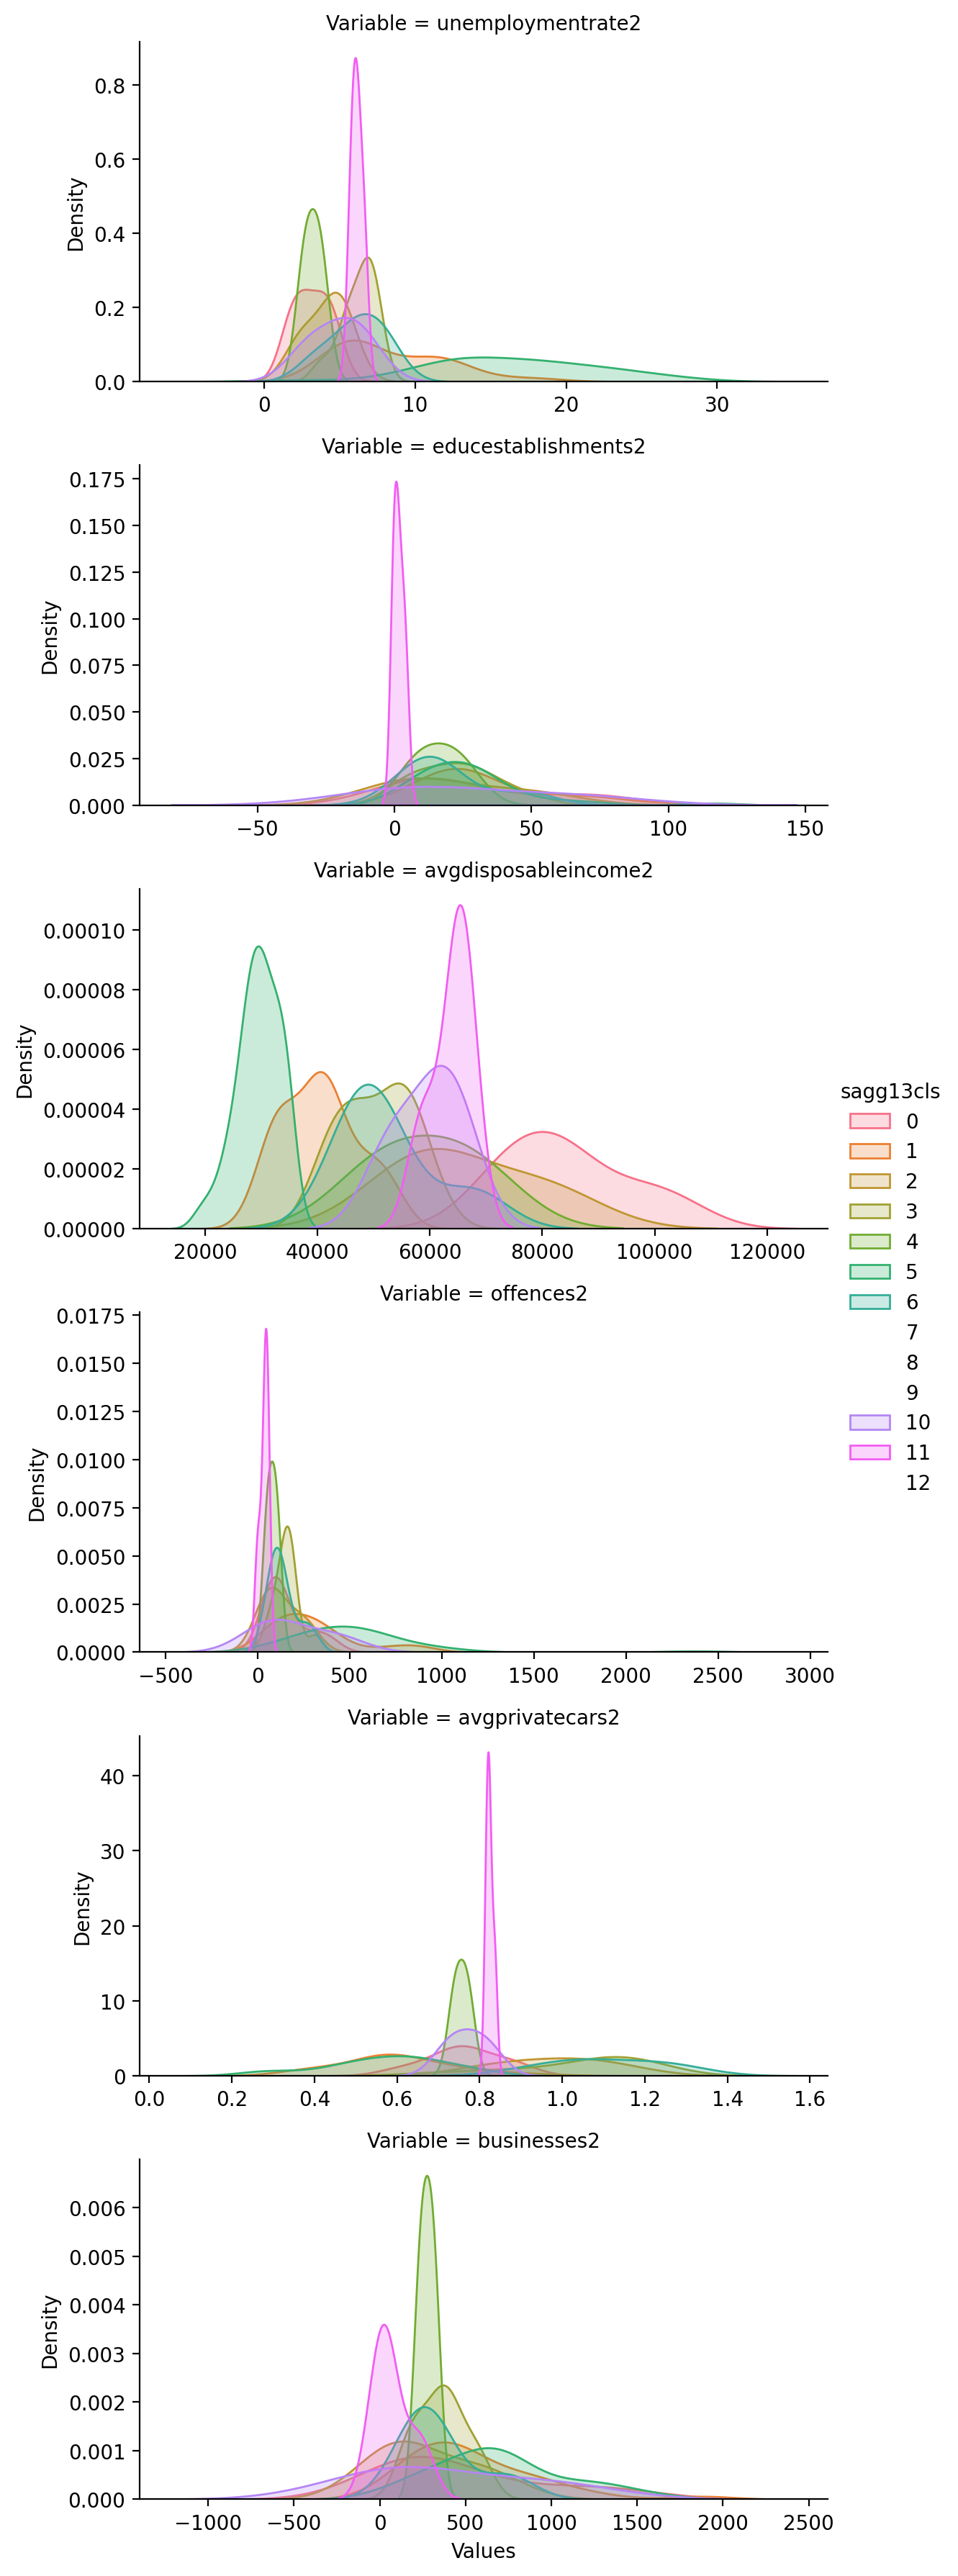

In [244]:
hague_new_ = hague_new.drop(columns='geometry')

# Set up plot data
plot_data = hague_new_.set_index('sagg13cls')
plot_data = plot_data.stack()
plot_data = plot_data.reset_index()
plot_data = plot_data.rename(columns={'level_1': 'Variable', 0: 'Values'})

# Set up facets and plot
facets = sns.FacetGrid(data=plot_data, row='Variable', hue='sagg13cls', \
                  sharey=False, sharex=False, aspect=2)
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

plt.show()
